## 라이브러리 설치

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,540 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and dire

In [1]:
!pip install lightgbm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LGBM

## 라이브러리 import

In [3]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.preprocessing import OneHotEncoder

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')

In [4]:
# seed 고정
SD = 42
random.seed(SD)
np.random.seed(SD)
os.environ['PYTHONHASHSEED'] = str(SD)

## 데이터 preprocessing

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Aimers/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Aimers/data/test.csv')

In [6]:
# ID 분리
test_ids = test_df['ID']  # ID 컬럼 따로 저장
train_df.drop(columns=['ID'], inplace=True)
test_df.drop(columns=['ID'], inplace=True)

In [7]:
train_df['배아 생성 주요 이유'].value_counts()

배아 생성 주요 이유
현재 시술용                 233732
배아 저장용                   9192
기증용, 현재 시술용              3784
난자 저장용                   1959
기증용                      1108
기증용, 배아 저장용               125
배아 저장용, 현재 시술용             83
기증용, 난자 저장용                44
기증용, 배아 저장용, 현재 시술용        20
난자 저장용, 배아 저장용              6
난자 저장용, 현재 시술용              5
연구용, 현재 시술용                 1
난자 저장용, 배아 저장용, 연구용         1
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

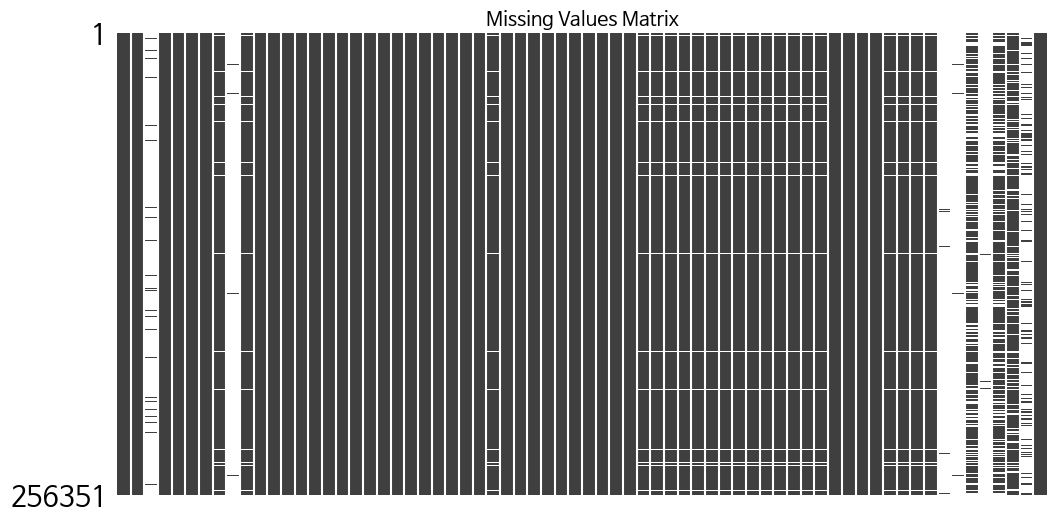

<Figure size 1000x500 with 0 Axes>

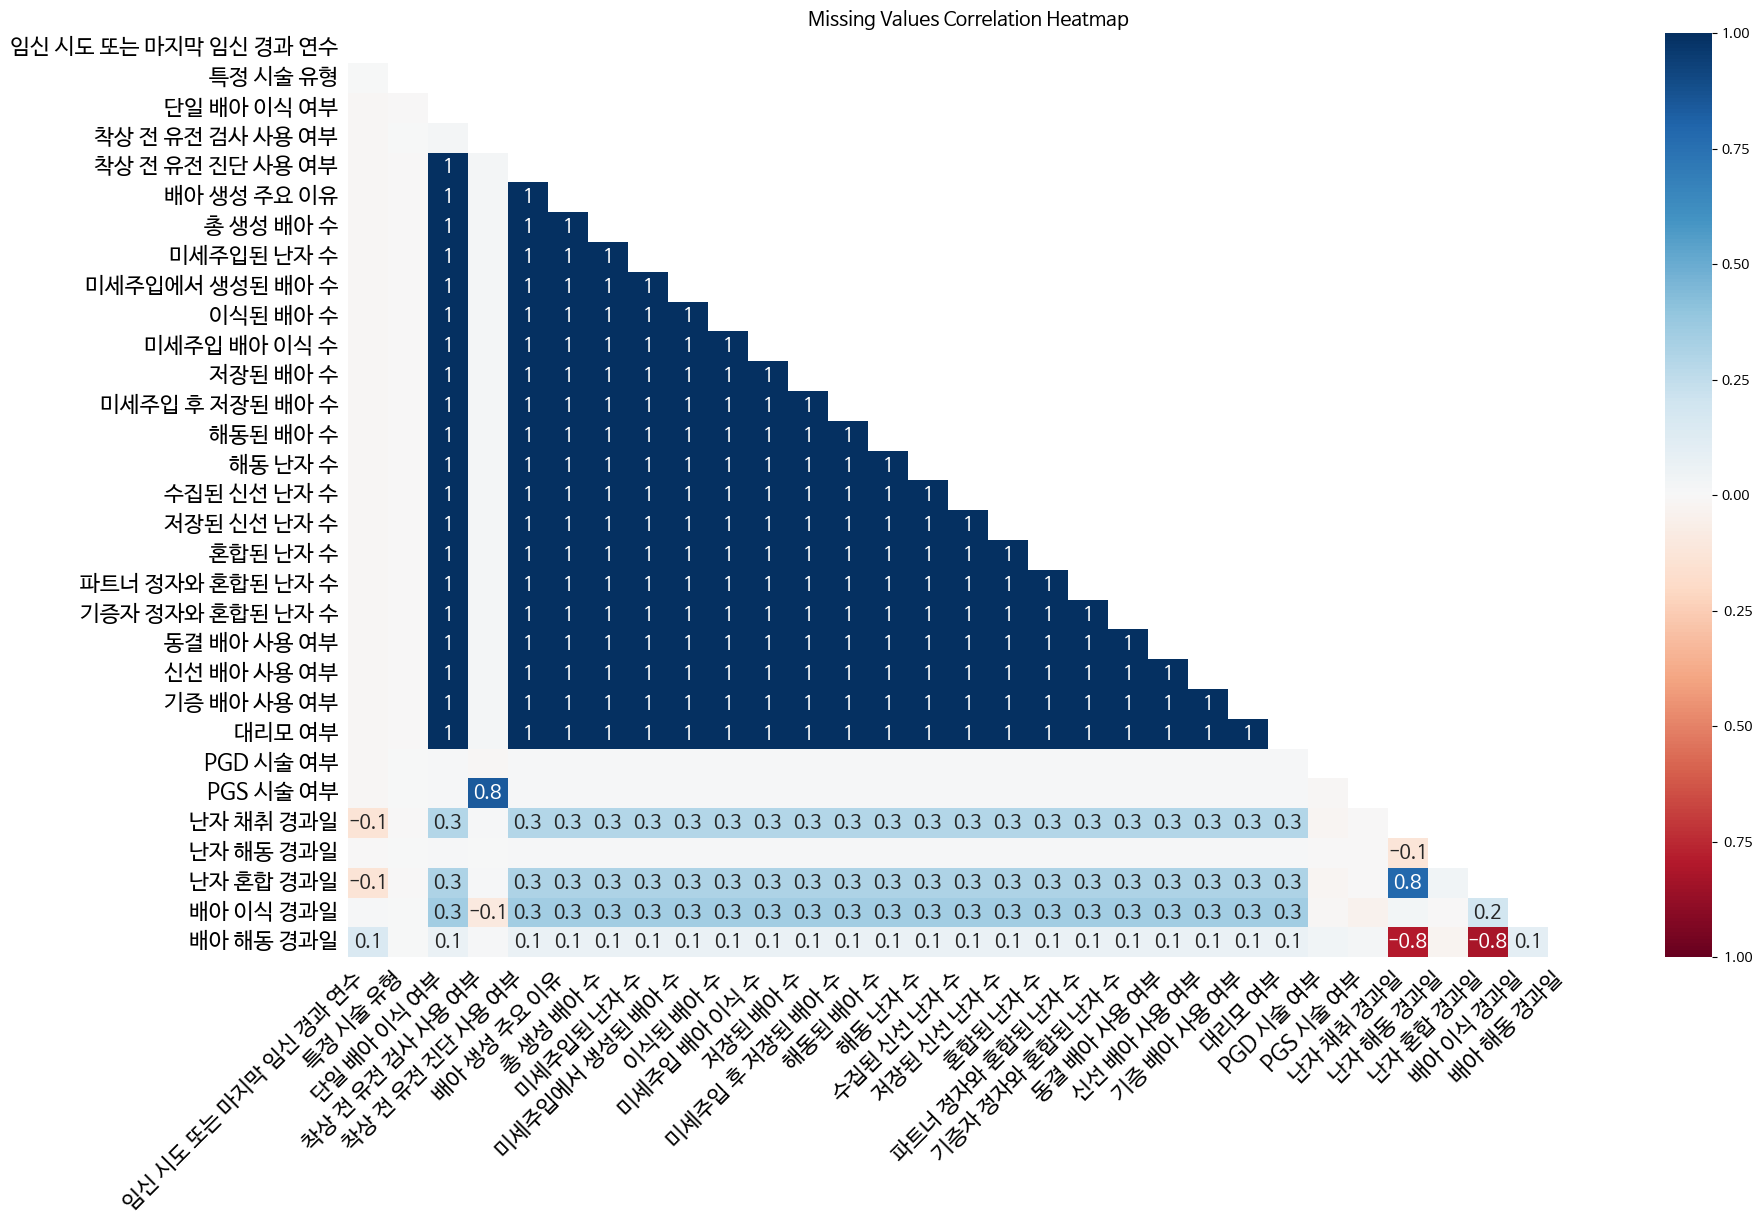

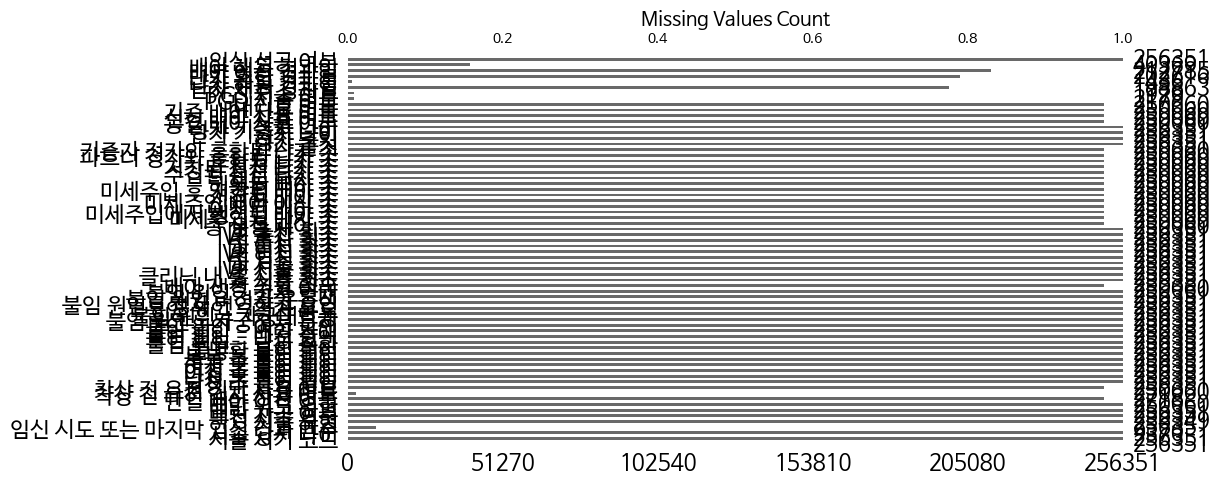

In [8]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# 결측치 시각화
plt.figure(figsize=(12, 6))
msno.matrix(train_df, figsize=(12, 6), sparkline=False)
plt.title("Missing Values Matrix", fontsize=14)
plt.show()

# 결측치 비율 히트맵 시각화
plt.figure(figsize=(10, 5))
msno.heatmap(train_df)
plt.title("Missing Values Correlation Heatmap", fontsize=14)
plt.show()

# 결측치 개수 막대 그래프
plt.figure(figsize=(10, 5))
msno.bar(train_df, figsize=(10, 5))
plt.title("Missing Values Count", fontsize=14)
plt.show()


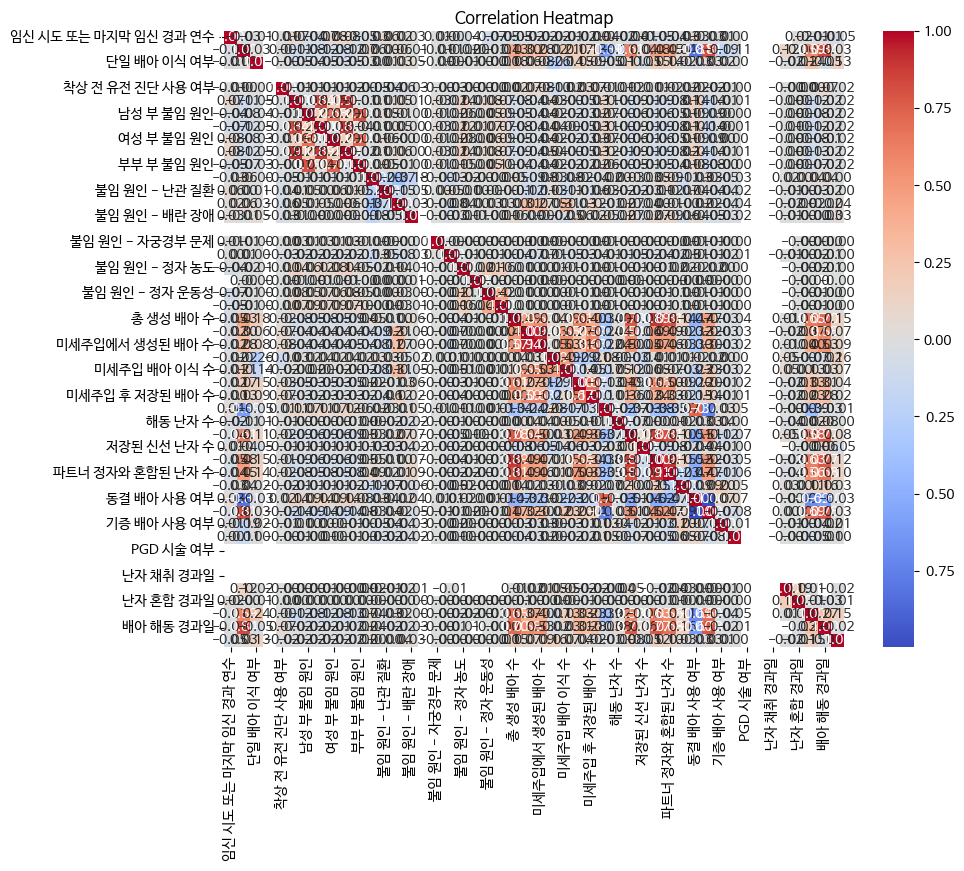

In [15]:
# 상관관계 시각화 (수치형 변수만)
corr_matrix = train_df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# 난자 출처 알 수 없음 -> 본인제공 replace
train_df['난자 출처'] = train_df['난자 출처'].replace('알 수 없음', '본인 제공')
test_df['난자 출처'] = test_df['난자 출처'].replace('알 수 없음', '본인 제공')

"# 난자 출처 알 수 없음 -> 본인제공 replace\ntrain_df['난자 출처'] = train_df['난자 출처'].replace('알 수 없음', '본인 제공')\ntest_df['난자 출처'] = test_df['난자 출처'].replace('알 수 없음', '본인 제공')"

In [ ]:
# Unknown
train_df['특정 시술 유형'] = train_df['특정 시술 유형'].fillna('Unknown')
test_df['특정 시술 유형'] = test_df['특정 시술 유형'].fillna('Unknown')

# 특정 컬럼 먼저 대체
s_col = ['PGD 시술 여부', '착상 전 유전 검사 사용 여부', 'PGS 시술 여부']
train_df[s_col] = train_df[s_col].fillna(0)
test_df[s_col] = test_df[s_col].fillna(0)

# IVF가 아닌 DI의 경우 결측치 대체
# 설문 조사에서 DI의 경우 대답할 필요가 없는 항목들이 결측치로 들어간 듯
columns_to_update = ['단일 배아 이식 여부', '착상 전 유전 진단 사용 여부', '배아 생성 주요 이유',
                     '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수',
                     '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수','미세주입 후 저장된 배아 수',
                     '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
                     '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수',
                     '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부']

# Process train_df
for column in columns_to_update:
    if train_df[column].dtype == 'object':
        # object 타입이면 'Not Answer(DI)'로 채우기
        train_df[column] = train_df[column].fillna('Not Answer(DI)')
    elif train_df[column].dtype in ['float64', 'int64']:
        # 숫자 타입이면 0로 채우기
        train_df[column] = train_df[column].fillna(0)

# Process test_df
for column in columns_to_update:
    if test_df[column].dtype == 'object':
        # object 타입이면 'Not Answer(DI)'로 채우기
        test_df[column] = test_df[column].fillna('Not Answer(DI)')
    elif test_df[column].dtype in ['float64', 'int64']:
        # 숫자 타입이면 0로 채우기
        test_df[column] = test_df[column].fillna(0)

# 경과일 컬럼 대체
o_col = ['난자 채취 경과일']
train_df[o_col] = train_df[o_col].fillna(1)
test_df[o_col] = test_df[o_col].fillna(1)

d_col = ['난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일']
train_df[d_col] = train_df[d_col].fillna(999)
test_df[d_col] = test_df[d_col].fillna(999)

In [ ]:
# 횟수, 회 타입 변경
int_col = ['총 시술 횟수','클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
           '총 임신 횟수', 'IVF 임신 횟수','DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수',
           'DI 출산 횟수']

for col in int_col:
    train_df[col] = train_df[col].astype(str).str.extract('(\d+)').astype(int)
    test_df[col] = test_df[col].astype(str).str.extract('(\d+)').astype(int)

In [ ]:
# 값이 1인 항목의 이름 추출
to_drop = train_df['배란 유도 유형'].value_counts()[train_df['배란 유도 유형'].value_counts() == 1].index

# 해당 항목 제거
train_df = train_df[~train_df['배란 유도 유형'].isin(to_drop)]

In [ ]:
# 조건 : 난자 출처 == "본인 제공" → 난자 기증자 나이를 시술 당시 나이로 설정
condition2 = (train_df['난자 출처'] == "본인 제공")
train_df.loc[condition2, '난자 기증자 나이'] = train_df.loc[condition2, '시술 당시 나이']

condition2_t = (test_df['난자 출처'] == "본인 제공")
test_df.loc[condition2_t, '난자 기증자 나이'] = test_df.loc[condition2_t, '시술 당시 나이']

In [ ]:
# 1. '불임 원인'이 포함된 모든 컬럼 리스트 생성
infertility_cols = [col for col in train_df.columns if '불임 원인' in col]

# 각 행에서 '불임 원인' 컬럼 중 1이 존재하는 경우 1
train_df['불임 원인 카운트'] = train_df[infertility_cols].sum(axis=1)
train_df['불임 원인 카운트'] = train_df['불임 원인 카운트'].apply(lambda x: 1 if x > 0 else 0)

test_df['불임 원인 카운트'] = test_df[infertility_cols].sum(axis=1)
test_df['불임 원인 카운트'] = test_df['불임 원인 카운트'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# 컬럼 drop
drop_col = ['임신 시도 또는 마지막 임신 경과 연수', '난자 해동 경과일', '불임 원인 - 정자 형태', '불임 원인 - 정자 운동성',
            '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 농도', '불임 원인 - 자궁경부 문제', '불임 원인 - 여성 요인',
            '대리모 여부', '부부 부 불임 원인']

train_df.drop(drop_col, axis=1, inplace=True)
test_df.drop(drop_col, axis=1, inplace=True)

## 키워드 추출

In [ ]:
# 키워드 리스트 정의 (우선순위 반영)
keywords = ['기증용', '현재 시술용', '난자 저장용', '배아 저장용']

# 각 키워드에 대해 새로운 컬럼 생성 (초기값 0 설정)
for keyword in keywords:
    train_df[keyword] = train_df['배아 생성 주요 이유'].str.contains(keyword).astype(int)
    test_df[keyword] = test_df['배아 생성 주요 이유'].str.contains(keyword).astype(int)

# 기존 컬럼 삭제
train_df.drop('배아 생성 주요 이유', axis=1, inplace=True)
test_df.drop('배아 생성 주요 이유', axis=1, inplace=True)

In [ ]:
# 키워드 리스트 정의
unique_types = ['ICSI', 'IVF', 'Unknown', 'IUI',
                'BLASTOCYST', 'AH']# 'ICI', 'GenericDI', 'IVI'

# 각 키워드에 대해 새로운 컬럼 생성
for keyword in unique_types:
    train_df[keyword] = train_df['특정 시술 유형'].str.count(keyword)
    test_df[keyword] = test_df['특정 시술 유형'].str.count(keyword)

# 기존 col drop
train_df.drop('특정 시술 유형', axis=1, inplace=True)
test_df.drop('특정 시술 유형', axis=1, inplace=True)

## 파생변수

In [ ]:
# 시술 받았는데 임신을 못한 경우 = 난임
train_df['난임 여부'] = train_df['총 시술 횟수'] - train_df['총 임신 횟수']
test_df['난임 여부'] = test_df['총 시술 횟수'] - test_df['총 임신 횟수']

# DI 난임
train_df['DI 난임 여부'] = train_df['DI 시술 횟수'] - train_df['DI 임신 횟수']
test_df['DI 난임 여부'] = test_df['DI 시술 횟수'] - test_df['DI 임신 횟수']

# 임신을 했는데 출산을 못한경우 = 유산
train_df['유산 여부'] = train_df['총 임신 횟수'] - train_df['총 출산 횟수']
train_df['유산 여부'] = train_df['유산 여부'].apply(lambda x: 1 if x > 0 else 0)

test_df['유산 여부'] = test_df['총 임신 횟수'] - test_df['총 출산 횟수']
test_df['유산 여부'] = test_df['유산 여부'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# 미세주입(ICSI) 아닌 IVF
train_df['미세주입이 아닌 배아 이식 수'] = train_df['이식된 배아 수'] - train_df['미세주입 배아 이식 수']
test_df['미세주입이 아닌 배아 이식 수'] = test_df['이식된 배아 수'] - test_df['미세주입 배아 이식 수']

train_df['미세주입이 아닌 배아 생성 수'] = train_df['총 생성 배아 수'] - train_df['미세주입에서 생성된 배아 수']
test_df['미세주입이 아닌 배아 생성 수'] = test_df['총 생성 배아 수'] - test_df['미세주입에서 생성된 배아 수']

train_df['미세주입이 아닌 배아 저장 수'] = train_df['저장된 배아 수'] - train_df['미세주입 후 저장된 배아 수']
test_df['미세주입이 아닌 배아 저장 수'] = test_df['저장된 배아 수'] - test_df['미세주입 후 저장된 배아 수']

In [ ]:
train_df['클리닉 외 총 시술 횟수'] = train_df['총 시술 횟수'] - train_df['클리닉 내 총 시술 횟수']
test_df['클리닉 외 총 시술 횟수'] = test_df['총 시술 횟수'] - test_df['클리닉 내 총 시술 횟수']

train_df['PGS 검사를 받고도 안한 사람'] = train_df['착상 전 유전 검사 사용 여부'] - train_df['PGS 시술 여부']
test_df['PGS 검사를 받고도 안한 사람'] = test_df['착상 전 유전 검사 사용 여부'] - test_df['PGS 시술 여부']

## 배아 변수

In [ ]:
# 단일 배아의 경우 더 성공률이 높음
train_df.loc[(train_df['단일 배아 이식 여부'] == 1) & (train_df['이식된 배아 수'] == 1), '이식된 배아 수'] = 1.5
test_df.loc[(test_df['단일 배아 이식 여부'] == 1) & (test_df['이식된 배아 수'] == 1), '이식된 배아 수'] = 1.5

# PGS 검사를 받고도 시술을 안하는건 다른 케이스로
train_df.loc[(train_df['착상 전 유전 검사 사용 여부'] == 1) & (train_df['PGS 시술 여부'] == 0), 'PGS 시술 여부'] = -1
test_df.loc[(test_df['착상 전 유전 검사 사용 여부'] == 1) & (test_df['PGS 시술 여부'] == 0), 'PGS 시술 여부'] = -1

In [ ]:
# 이식 배아 수/ 나이
# 나이 재 정의
age_bin_mapping = {
    "만18-34세": 1,
    "만35-37세": 2,
    "만38-39세": 3,
    "만40-42세": 4,
    "만43-44세": 5,
    "만45-50세": 6,
    "알 수 없음": 7
}

# 나이  적용
train_df['나이'] = train_df['시술 당시 나이'].map(age_bin_mapping)
test_df['나이'] = test_df['시술 당시 나이'].map(age_bin_mapping)

# 나이 별 배아수
train_df['이식 배아 수/나이'] = train_df['이식된 배아 수'] / train_df['나이']
test_df['이식 배아 수/나이'] = test_df['이식된 배아 수'] / test_df['나이']

# 나이 drop
train_df.drop('나이', axis=1, inplace=True)
test_df.drop('나이', axis=1, inplace=True)

## 범주형/수치형

In [ ]:
# categorical로 바꿔줌
cat_col = ['배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부',
 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인',
  '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
 '불임 원인 - 자궁내막증', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수',
 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '동결 배아 사용 여부',
 '신선 배아 사용 여부', '기증 배아 사용 여부',  'PGD 시술 여부', 'PGS 시술 여부', '기증용', '현재 시술용',
  '난자 저장용', '배아 저장용', 'ICSI', 'IVF', 'Unknown', 'IUI', 'BLASTOCYST', 'AH', '난임 여부', '유산 여부',
'DI 난임 여부']


for col in cat_col:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

In [ ]:
# 범주형 변수 지정 (CatBoost에서 처리하도록 설정)
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# 범주형 변수를 category 타입으로 변환
for col in categorical_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")  # 테스트 데이터도 변환

## 모델링

In [ ]:
# 타겟 분리
y_train = train_df['임신 성공 여부']
X_train = train_df.drop(columns=['임신 성공 여부'])
X_test = test_df.copy()

## 클래스 가중치 계산
class_counts = y_train.value_counts()
pos_weight = class_counts[0] / class_counts[1]

## K-Fold 검증 (가중치 적용)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SD)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'random_state': SD
}

f1_scores, auc_scores, acc_scores = [], [], []
all_y_pred_proba = []
all_y_true = []
models = []  # 각 Fold 모델 저장
test_pred_proba_list = []  # 테스트 데이터 예측 저장

for train_idx, valid_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # LightGBM 데이터셋 생성 시 categorical_feature 설정
    lgb_train = lgb.Dataset(X_tr, label=y_tr, weight=y_tr.map({0: 1, 1: pos_weight}), categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(X_val, label=y_val, weight=y_val.map({0: 1, 1: pos_weight}), categorical_feature=categorical_features)

    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], callbacks=[early_stopping(50), log_evaluation(50)])
    models.append(model)  # 모델 저장

    y_pred_proba = model.predict(X_val)
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    f1_scores.append(f1_score(y_val, y_pred_binary))
    auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    acc_scores.append(accuracy_score(y_val, y_pred_binary))

    all_y_pred_proba.extend(y_pred_proba)
    all_y_true.extend(y_val)

    # 테스트 데이터 예측 저장
    test_pred_proba_list.append(model.predict(X_test))

print(f"Mean F1-score: {np.mean(f1_scores):.5f}, AUC: {np.mean(auc_scores):.5f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 52982, number of negative: 152097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 837
[LightGBM] [Info] Number of data points in the train set: 205079, number of used features: 75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.737936
[100]	valid_0's auc: 0.737937
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.738196
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Light

# 분석

## 모델 지표

In [ ]:
df = train_df.copy()
df['시술 합'] = df['IVF 시술 횟수'].astype(int) + df['DI 시술 횟수'].astype(int)

# 시술 합과 총 시술 횟수가 같은지 확인
pd.crosstab(df['시술 합'], df['총 시술 횟수'])

총 시술 횟수      0      1      2      3      4     5      6
시술 합                                                   
0        97599      0      0      0      0     0      0
1            0  56818      0      0      0     0      0
2            0      0  39338      0      0     0      0
3            0      0      0  24531      0     0      0
4            0      0      0      0  15141     0      0
5            0      0      0      0      0  9106      0
6            0      0      0      0      0     0  11252
7            0      0      0      0      0     0   1034
8            0      0      0      0      0     0    674
9            0      0      0      0      0     0    394
10           0      0      0      0      0     0    231
11           0      0      0      0      0     0    126
12           0      0      0      0      0     0    105

In [ ]:
pd.crosstab(df['시술 합'], df['임신 성공 여부'], normalize='index')

임신 성공 여부         0         1
시술 합                        
0         0.709013  0.290987
1         0.750062  0.249938
2         0.755834  0.244166
3         0.763646  0.236354
4         0.772208  0.227792
5         0.784208  0.215792
6         0.798969  0.201031
7         0.786267  0.213733
8         0.781899  0.218101
9         0.769036  0.230964
10        0.805195  0.194805
11        0.809524  0.190476
12        0.819048  0.180952

In [ ]:
df['임신 합'] = df['IVF 임신 횟수'].astype(int) + df['DI 임신 횟수'].astype(int)

# 임신 합과 총 임신 횟수가 같은지 확인
pd.crosstab(df['임신 합'], df['총 임신 횟수'])

총 임신 횟수       0      1     2    3   4  5  6
임신 합                                       
0        205425      0     0    0   0  0  0
1             0  43829     0    0   0  0  0
2             0      0  6246    0   0  0  0
3             0      0     0  746   0  0  0
4             0      0     0    0  92  0  0
5             0      0     0    0   0  8  0
6             0      0     0    0   0  0  3

In [ ]:
df['출산 합'] = df['IVF 출산 횟수'].astype(int) + df['DI 출산 횟수'].astype(int)

# 출산 합과 총 출산 횟수가
pd.crosstab(df['출산 합'], df['총 출산 횟수'])

총 출산 횟수       0      1     2    3   4  5  6
출산 합                                       
0        218554      0     0    0   0  0  0
1             0  35368     0    0   0  0  0
2             0      0  2242    0   0  0  0
3             0      0     0  169   0  0  0
4             0      0     0    0  13  0  0
5             0      0     0    0   0  1  0
6             0      0     0    0   0  0  2

In [ ]:
pd.crosstab(df['배란 자극 여부'], df['배란 유도 유형'])

배란 유도 유형  기록되지 않은 시행  알 수 없음
배란 자극 여부                    
0                  0   58631
1             194432    3286

In [ ]:
pd.crosstab([df['배란 자극 여부'], df['배란 유도 유형']],df['임신 성공 여부'], normalize='index')

임신 성공 여부                    0         1
배란 자극 여부 배란 유도 유형                      
0        알 수 없음      0.768348  0.231652
1        기록되지 않은 시행  0.731593  0.268407
         알 수 없음      0.860621  0.139379

In [ ]:
pd.crosstab([df['배란 자극 여부'], df['배란 유도 유형']],df['시술 유형'], normalize='index')

시술 유형                      DI       IVF
배란 자극 여부 배란 유도 유형                      
0        알 수 없음      0.051253  0.948747
1        기록되지 않은 시행  0.000000  1.000000
         알 수 없음      1.000000  0.000000

In [ ]:
pd.crosstab(df['배란 유도 유형'],df['시술 유형'], normalize='index')

시술 유형             DI       IVF
배란 유도 유형                      
기록되지 않은 시행  0.000000  1.000000
알 수 없음      0.101604  0.898396

In [ ]:
for i in range(1,74):
    print(i)
    display(train_df.iloc[:, i].value_counts(dropna=False))

    temp_col = train_df.iloc[:, i] # Replace NaN with a string to include in crosstab
    crosstab_result = pd.crosstab(temp_col, train_df['임신 성공 여부'], normalize='index')

    display(crosstab_result)
    print('\n')

1


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39246
만40-42세     37347
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

임신 성공 여부         0         1
시술 당시 나이                    
만18-34세   0.677378  0.322622
만35-37세   0.721599  0.278401
만38-39세   0.782857  0.217143
만40-42세   0.840630  0.159370
만43-44세   0.881988  0.118012
만45-50세   0.832321  0.167679
알 수 없음    1.000000  0.000000



2


시술 유형
IVF    250058
DI       6291
Name: count, dtype: int64

임신 성공 여부         0         1
시술 유형                       
DI        0.871086  0.128914
IVF       0.738397  0.261603



3


배란 자극 여부
1    197718
0     58631
Name: count, dtype: int64

임신 성공 여부         0         1
배란 자극 여부                    
0         0.768348  0.231652
1         0.733737  0.266263



4


배란 유도 유형
기록되지 않은 시행    194432
알 수 없음         61917
Name: count, dtype: int64

임신 성공 여부           0         1
배란 유도 유형                      
기록되지 않은 시행  0.731593  0.268407
알 수 없음      0.773245  0.226755



5


단일 배아 이식 여부
0.0    197966
1.0     58383
Name: count, dtype: int64

임신 성공 여부            0         1
단일 배아 이식 여부                    
0.0          0.773764  0.226236
1.0          0.632770  0.367230



6


착상 전 유전 검사 사용 여부
0.0    253631
1.0      2718
Name: count, dtype: int64

임신 성공 여부                 0         1
착상 전 유전 검사 사용 여부                    
0.0               0.740473  0.259527
1.0               0.851729  0.148271



7


착상 전 유전 진단 사용 여부
0.0    253153
1.0      3196
Name: count, dtype: int64

임신 성공 여부                 0         1
착상 전 유전 진단 사용 여부                    
0.0               0.740817  0.259183
1.0               0.807885  0.192115



8


남성 주 불임 원인
0    249041
1      7308
Name: count, dtype: int64

임신 성공 여부           0         1
남성 주 불임 원인                    
0           0.740525  0.259475
1           0.780104  0.219896



9


남성 부 불임 원인
0    252987
1      3362
Name: count, dtype: int64

임신 성공 여부           0         1
남성 부 불임 원인                    
0           0.740844  0.259156
1           0.802499  0.197501



10


여성 주 불임 원인
0    248475
1      7874
Name: count, dtype: int64

임신 성공 여부           0         1
여성 주 불임 원인                    
0           0.740408  0.259592
1           0.780925  0.219075



11


여성 부 불임 원인
0    253162
1      3187
Name: count, dtype: int64

임신 성공 여부           0         1
여성 부 불임 원인                    
0           0.740866  0.259134
1           0.804205  0.195795



12


부부 주 불임 원인
0    247874
1      8475
Name: count, dtype: int64

임신 성공 여부           0         1
부부 주 불임 원인                    
0           0.740348  0.259652
1           0.779823  0.220177



13


불명확 불임 원인
0    192074
1     64275
Name: count, dtype: int64

임신 성공 여부          0         1
불명확 불임 원인                    
0          0.742027  0.257973
1          0.740537  0.259463



14


불임 원인 - 난관 질환
0    220792
1     35557
Name: count, dtype: int64

임신 성공 여부              0         1
불임 원인 - 난관 질환                    
0              0.741558  0.258442
1              0.742245  0.257755



15


불임 원인 - 남성 요인
0    160885
1     95464
Name: count, dtype: int64

임신 성공 여부              0         1
불임 원인 - 남성 요인                    
0              0.754433  0.245567
1              0.720114  0.279886



16


불임 원인 - 배란 장애
0    222923
1     33426
Name: count, dtype: int64

임신 성공 여부              0         1
불임 원인 - 배란 장애                    
0              0.745894  0.254106
1              0.713367  0.286633



17


불임 원인 - 자궁내막증
0    238047
1     18302
Name: count, dtype: int64

임신 성공 여부              0         1
불임 원인 - 자궁내막증                    
0              0.741383  0.258617
1              0.745164  0.254836



18


총 시술 횟수
0    97599
1    56818
2    39338
3    24531
4    15141
6    13816
5     9106
Name: count, dtype: int64

임신 성공 여부         0         1
총 시술 횟수                     
0         0.709013  0.290987
1         0.750062  0.249938
2         0.755834  0.244166
3         0.763646  0.236354
4         0.772208  0.227792
5         0.784208  0.215792
6         0.796685  0.203315



19


클리닉 내 총 시술 횟수
0    121675
1     59751
2     34562
3     18357
4     10018
6      6590
5      5396
Name: count, dtype: int64

임신 성공 여부              0         1
클리닉 내 총 시술 횟수                    
0              0.717082  0.282918
1              0.754632  0.245368
2              0.762051  0.237949
3              0.767555  0.232445
4              0.778099  0.221901
5              0.792439  0.207561
6              0.801517  0.198483



20


IVF 시술 횟수
0    103934
1     58338
2     39177
3     23280
4     13660
6     10158
5      7802
Name: count, dtype: int64

임신 성공 여부          0         1
IVF 시술 횟수                    
0          0.713741  0.286259
1          0.749443  0.250557
2          0.754550  0.245450
3          0.764476  0.235524
4          0.772548  0.227452
5          0.787234  0.212766
6          0.803898  0.196102



21


DI 시술 횟수
0    242462
3      3116
2      3006
1      2920
6      1917
4      1727
5      1201
Name: count, dtype: int64

임신 성공 여부         0         1
DI 시술 횟수                    
0         0.739349  0.260651
1         0.807877  0.192123
2         0.782768  0.217232
3         0.757702  0.242298
4         0.779386  0.220614
5         0.811823  0.188177
6         0.763693  0.236307



22


총 임신 횟수
0    205425
1     43829
2      6246
3       746
4        92
5         8
6         3
Name: count, dtype: int64

임신 성공 여부         0         1
총 임신 횟수                     
0         0.742548  0.257452
1         0.737092  0.262908
2         0.742075  0.257925
3         0.754692  0.245308
4         0.782609  0.217391
5         0.750000  0.250000
6         0.666667  0.333333



23


IVF 임신 횟수
0    208291
1     41519
2      5788
3       663
4        80
5         7
6         1
Name: count, dtype: int64

임신 성공 여부          0         1
IVF 임신 횟수                    
0          0.743153  0.256847
1          0.733592  0.266408
2          0.743953  0.256047
3          0.752640  0.247360
4          0.762500  0.237500
5          0.857143  0.142857
6          0.000000  1.000000



24


DI 임신 횟수
0    253300
1      2625
2       368
3        48
4         5
5         3
Name: count, dtype: int64

임신 성공 여부         0         1
DI 임신 횟수                    
0         0.741153  0.258847
1         0.790857  0.209143
2         0.725543  0.274457
3         0.791667  0.208333
4         1.000000  0.000000
5         0.666667  0.333333



25


총 출산 횟수
0    218554
1     35368
2      2242
3       169
4        13
6         2
5         1
Name: count, dtype: int64

임신 성공 여부         0         1
총 출산 횟수                     
0         0.743153  0.256847
1         0.732753  0.267247
2         0.736842  0.263158
3         0.721893  0.278107
4         0.769231  0.230769
5         1.000000  0.000000
6         1.000000  0.000000



26


IVF 출산 횟수
0    220830
1     33347
2      2021
3       137
4        13
5         1
Name: count, dtype: int64

임신 성공 여부          0         1
IVF 출산 횟수                    
0          0.743459  0.256541
1          0.730111  0.269889
2          0.737259  0.262741
3          0.700730  0.299270
4          0.769231  0.230769
5          1.000000  0.000000



27


DI 출산 횟수
0    254007
1      2138
2       183
3        19
5         2
Name: count, dtype: int64

임신 성공 여부         0         1
DI 출산 횟수                    
0         0.741385  0.258615
1         0.770814  0.229186
2         0.765027  0.234973
3         0.789474  0.210526
5         1.000000  0.000000



28


총 생성 배아 수
0.0     59640
4.0     21612
3.0     20951
5.0     20410
2.0     19190
6.0     18623
7.0     16029
1.0     15223
8.0     13619
9.0     11131
10.0     9065
11.0     7090
12.0     5720
13.0     4321
14.0     3360
15.0     2516
16.0     1916
17.0     1504
18.0     1117
19.0      799
20.0      640
21.0      461
22.0      354
23.0      266
24.0      195
25.0      163
26.0      105
27.0       84
28.0       51
29.0       46
30.0       40
31.0       25
32.0       23
34.0       15
33.0       12
37.0        7
36.0        7
35.0        4
42.0        3
38.0        3
44.0        3
51.0        2
41.0        2
40.0        1
43.0        1
Name: count, dtype: int64

임신 성공 여부          0         1
총 생성 배아 수                    
0.0        0.832663  0.167337
1.0        0.905144  0.094856
2.0        0.819906  0.180094
3.0        0.758150  0.241850
4.0        0.722700  0.277300
5.0        0.694561  0.305439
6.0        0.677012  0.322988
7.0        0.661676  0.338324
8.0        0.649974  0.350026
9.0        0.645674  0.354326
10.0       0.639603  0.360397
11.0       0.633145  0.366855
12.0       0.647552  0.352448
13.0       0.633881  0.366119
14.0       0.644048  0.355952
15.0       0.642289  0.357711
16.0       0.652923  0.347077
17.0       0.677527  0.322473
18.0       0.696509  0.303491
19.0       0.692115  0.307885
20.0       0.714063  0.285938
21.0       0.735358  0.264642
22.0       0.748588  0.251412
23.0       0.789474  0.210526
24.0       0.800000  0.200000
25.0       0.797546  0.202454
26.0       0.790476  0.209524
27.0       0.761905  0.238095
28.0       0.843137  0.156863
29.0       0.782609  0.217391
30.0       0.825000  0.175000
31.0       0.880000  0.120000
32.0       0.739130  0.260870
33.0       0.833333  0.166667
34.0       0.666667  0.333333
35.0       1.000000  0.000000
36.0       0.857143  0.142857
37.0       0.857143  0.142857
38.0       1.000000  0.000000
40.0       1.000000  0.000000
41.0       1.000000  0.000000
42.0       1.000000  0.000000
43.0       1.000000  0.000000
44.0       1.000000  0.000000
51.0       1.000000  0.000000



29


미세주입된 난자 수
0.0     133960
6.0      11074
5.0      10619
7.0      10411
8.0       9699
4.0       9622
9.0       8606
3.0       7912
10.0      7748
11.0      6527
2.0       6294
12.0      5622
13.0      4651
1.0       4537
14.0      3842
15.0      3191
16.0      2559
17.0      1964
18.0      1594
19.0      1224
20.0       997
21.0       796
22.0       656
23.0       489
24.0       363
25.0       281
26.0       241
27.0       185
28.0       165
29.0       113
30.0        92
31.0        60
32.0        52
33.0        39
34.0        35
35.0        31
36.0        27
37.0        14
38.0        11
40.0         8
43.0         7
39.0         7
51.0         5
45.0         4
46.0         3
42.0         3
41.0         3
47.0         2
48.0         1
49.0         1
44.0         1
50.0         1
Name: count, dtype: int64

임신 성공 여부           0         1
미세주입된 난자 수                    
0.0         0.754979  0.245021
1.0         0.942693  0.057307
2.0         0.888783  0.111217
3.0         0.833418  0.166582
4.0         0.789753  0.210247
5.0         0.744609  0.255391
6.0         0.723316  0.276684
7.0         0.704831  0.295169
8.0         0.693680  0.306320
9.0         0.681734  0.318266
10.0        0.665462  0.334538
11.0        0.650375  0.349625
12.0        0.660619  0.339381
13.0        0.642012  0.357988
14.0        0.661374  0.338626
15.0        0.650893  0.349107
16.0        0.657288  0.342712
17.0        0.658859  0.341141
18.0        0.680050  0.319950
19.0        0.665850  0.334150
20.0        0.673019  0.326981
21.0        0.717337  0.282663
22.0        0.730183  0.269817
23.0        0.711656  0.288344
24.0        0.763085  0.236915
25.0        0.779359  0.220641
26.0        0.775934  0.224066
27.0        0.832432  0.167568
28.0        0.830303  0.169697
29.0        0.769912  0.230088
30.0        0.826087  0.173913
31.0        0.866667  0.133333
32.0        0.807692  0.192308
33.0        0.820513  0.179487
34.0        0.857143  0.142857
35.0        0.870968  0.129032
36.0        0.925926  0.074074
37.0        0.785714  0.214286
38.0        0.909091  0.090909
39.0        0.857143  0.142857
40.0        0.875000  0.125000
41.0        1.000000  0.000000
42.0        0.666667  0.333333
43.0        0.857143  0.142857
44.0        1.000000  0.000000
45.0        1.000000  0.000000
46.0        1.000000  0.000000
47.0        1.000000  0.000000
48.0        1.000000  0.000000
49.0        1.000000  0.000000
50.0        1.000000  0.000000
51.0        1.000000  0.000000



30


미세주입에서 생성된 배아 수
0.0     138063
4.0      13883
3.0      13805
5.0      12923
2.0      12631
6.0      11587
1.0       9917
7.0       9516
8.0       7788
9.0       6173
10.0      4819
11.0      3739
12.0      2981
13.0      2151
14.0      1689
15.0      1208
16.0       884
17.0       695
18.0       503
19.0       349
20.0       267
21.0       204
22.0       145
23.0       118
24.0        78
25.0        68
26.0        39
27.0        35
29.0        21
28.0        20
30.0        16
32.0         8
34.0         6
31.0         6
33.0         6
41.0         2
42.0         2
36.0         1
43.0         1
38.0         1
37.0         1
Name: count, dtype: int64

임신 성공 여부                0         1
미세주입에서 생성된 배아 수                    
0.0              0.762101  0.237899
1.0              0.908541  0.091459
2.0              0.817908  0.182092
3.0              0.758276  0.241724
4.0              0.719729  0.280271
5.0              0.689546  0.310454
6.0              0.671874  0.328126
7.0              0.659416  0.340584
8.0              0.651130  0.348870
9.0              0.641665  0.358335
10.0             0.635817  0.364183
11.0             0.624231  0.375769
12.0             0.662865  0.337135
13.0             0.642027  0.357973
14.0             0.646536  0.353464
15.0             0.653974  0.346026
16.0             0.694570  0.305430
17.0             0.661871  0.338129
18.0             0.693837  0.306163
19.0             0.702006  0.297994
20.0             0.711610  0.288390
21.0             0.745098  0.254902
22.0             0.737931  0.262069
23.0             0.788136  0.211864
24.0             0.846154  0.153846
25.0             0.808824  0.191176
26.0             0.794872  0.205128
27.0             0.771429  0.228571
28.0             0.800000  0.200000
29.0             0.761905  0.238095
30.0             0.875000  0.125000
31.0             0.833333  0.166667
32.0             0.750000  0.250000
33.0             1.000000  0.000000
34.0             0.500000  0.500000
36.0             1.000000  0.000000
37.0             1.000000  0.000000
38.0             1.000000  0.000000
41.0             1.000000  0.000000
42.0             1.000000  0.000000
43.0             1.000000  0.000000



31


이식된 배아 수
2.0    110843
1.5     58360
0.0     42835
1.0     35431
3.0      8880
Name: count, dtype: int64

임신 성공 여부         0         1
이식된 배아 수                    
0.0       0.980367  0.019633
1.0       0.774943  0.225057
1.5       0.632728  0.367272
2.0       0.688911  0.311089
3.0       0.831532  0.168468



32


미세주입 배아 이식 수
0.0    145065
2.0     59683
1.0     46475
3.0      5126
Name: count, dtype: int64

임신 성공 여부             0         1
미세주입 배아 이식 수                    
0.0           0.780250  0.219750
1.0           0.680559  0.319441
2.0           0.687683  0.312317
3.0           0.831643  0.168357



33


저장된 배아 수
0.0     173155
1.0      20366
2.0      19879
3.0      13504
4.0       9249
5.0       5978
6.0       4114
7.0       2655
8.0       1877
9.0       1287
10.0      1014
11.0       634
12.0       535
13.0       396
14.0       345
15.0       254
16.0       197
17.0       179
18.0       170
20.0       109
19.0       100
21.0        75
22.0        67
23.0        67
24.0        38
25.0        32
26.0        16
27.0        12
30.0         9
28.0         8
29.0         7
32.0         4
34.0         3
41.0         2
51.0         2
36.0         2
37.0         2
31.0         2
42.0         1
38.0         1
33.0         1
44.0         1
Name: count, dtype: int64

임신 성공 여부         0         1
저장된 배아 수                    
0.0       0.781260  0.218740
1.0       0.654670  0.345330
2.0       0.629509  0.370491
3.0       0.630332  0.369668
4.0       0.639745  0.360255
5.0       0.650552  0.349448
6.0       0.667477  0.332523
7.0       0.705461  0.294539
8.0       0.714971  0.285029
9.0       0.740482  0.259518
10.0      0.781065  0.218935
11.0      0.828076  0.171924
12.0      0.841121  0.158879
13.0      0.911616  0.088384
14.0      0.936232  0.063768
15.0      0.929134  0.070866
16.0      0.928934  0.071066
17.0      0.977654  0.022346
18.0      0.982353  0.017647
19.0      0.980000  0.020000
20.0      0.981651  0.018349
21.0      0.986667  0.013333
22.0      1.000000  0.000000
23.0      0.955224  0.044776
24.0      0.973684  0.026316
25.0      1.000000  0.000000
26.0      1.000000  0.000000
27.0      1.000000  0.000000
28.0      1.000000  0.000000
29.0      1.000000  0.000000
30.0      1.000000  0.000000
31.0      1.000000  0.000000
32.0      1.000000  0.000000
33.0      1.000000  0.000000
34.0      1.000000  0.000000
36.0      1.000000  0.000000
37.0      1.000000  0.000000
38.0      1.000000  0.000000
41.0      1.000000  0.000000
42.0      1.000000  0.000000
44.0      1.000000  0.000000
51.0      1.000000  0.000000



34


미세주입 후 저장된 배아 수
0.0     210583
1.0      12341
2.0      11351
3.0       7430
4.0       4872
5.0       3022
6.0       1938
7.0       1279
8.0        874
9.0        617
10.0       467
11.0       290
12.0       259
13.0       200
14.0       175
15.0       128
16.0       104
18.0        81
17.0        80
19.0        52
20.0        44
22.0        32
23.0        32
21.0        31
24.0        19
25.0        17
27.0         8
26.0         4
30.0         4
29.0         4
28.0         3
32.0         2
42.0         1
41.0         1
34.0         1
43.0         1
38.0         1
51.0         1
Name: count, dtype: int64

임신 성공 여부                0         1
미세주입 후 저장된 배아 수                    
0.0              0.759344  0.240656
1.0              0.653513  0.346487
2.0              0.624791  0.375209
3.0              0.633647  0.366353
4.0              0.645731  0.354269
5.0              0.656188  0.343812
6.0              0.673375  0.326625
7.0              0.741986  0.258014
8.0              0.741419  0.258581
9.0              0.768233  0.231767
10.0             0.830835  0.169165
11.0             0.851724  0.148276
12.0             0.853282  0.146718
13.0             0.925000  0.075000
14.0             0.971429  0.028571
15.0             0.968750  0.031250
16.0             0.951923  0.048077
17.0             0.975000  0.025000
18.0             0.975309  0.024691
19.0             0.980769  0.019231
20.0             1.000000  0.000000
21.0             1.000000  0.000000
22.0             1.000000  0.000000
23.0             0.968750  0.031250
24.0             1.000000  0.000000
25.0             1.000000  0.000000
26.0             1.000000  0.000000
27.0             1.000000  0.000000
28.0             1.000000  0.000000
29.0             1.000000  0.000000
30.0             1.000000  0.000000
32.0             1.000000  0.000000
34.0             1.000000  0.000000
38.0             1.000000  0.000000
41.0             1.000000  0.000000
42.0             1.000000  0.000000
43.0             1.000000  0.000000
51.0             1.000000  0.000000



35


해동된 배아 수
0.0     215964
1.0      13056
2.0      12075
3.0       5394
4.0       3452
5.0       1937
6.0       1499
7.0        819
8.0        751
9.0        412
10.0       344
11.0       156
12.0       144
13.0        81
14.0        75
16.0        47
15.0        42
17.0        27
18.0        24
19.0        16
21.0         7
22.0         6
20.0         5
26.0         5
23.0         5
24.0         4
30.0         1
32.0         1
Name: count, dtype: int64

임신 성공 여부         0         1
해동된 배아 수                    
0.0       0.736072  0.263928
1.0       0.784697  0.215303
2.0       0.761242  0.238758
3.0       0.794957  0.205043
4.0       0.778679  0.221321
5.0       0.766133  0.233867
6.0       0.752502  0.247498
7.0       0.759463  0.240537
8.0       0.699068  0.300932
9.0       0.672330  0.327670
10.0      0.741279  0.258721
11.0      0.756410  0.243590
12.0      0.673611  0.326389
13.0      0.679012  0.320988
14.0      0.720000  0.280000
15.0      0.714286  0.285714
16.0      0.574468  0.425532
17.0      0.740741  0.259259
18.0      0.750000  0.250000
19.0      0.812500  0.187500
20.0      0.600000  0.400000
21.0      0.428571  0.571429
22.0      0.500000  0.500000
23.0      0.600000  0.400000
24.0      0.750000  0.250000
26.0      0.800000  0.200000
30.0      1.000000  0.000000
32.0      1.000000  0.000000



36


해동 난자 수
0.0     254904
8.0        219
6.0        171
7.0        143
4.0        130
5.0        107
9.0        105
10.0        91
12.0        70
11.0        67
2.0         65
3.0         65
14.0        44
15.0        37
13.0        32
1.0         26
16.0        20
17.0        14
19.0        12
18.0         7
20.0         5
24.0         3
23.0         2
21.0         2
26.0         2
32.0         1
25.0         1
36.0         1
33.0         1
27.0         1
22.0         1
Name: count, dtype: int64

임신 성공 여부         0         1
해동 난자 수                     
0.0       0.741448  0.258552
1.0       0.923077  0.076923
2.0       0.907692  0.092308
3.0       0.907692  0.092308
4.0       0.892308  0.107692
5.0       0.859813  0.140187
6.0       0.801170  0.198830
7.0       0.713287  0.286713
8.0       0.703196  0.296804
9.0       0.780952  0.219048
10.0      0.769231  0.230769
11.0      0.761194  0.238806
12.0      0.657143  0.342857
13.0      0.812500  0.187500
14.0      0.613636  0.386364
15.0      0.594595  0.405405
16.0      0.550000  0.450000
17.0      0.785714  0.214286
18.0      0.857143  0.142857
19.0      0.916667  0.083333
20.0      1.000000  0.000000
21.0      1.000000  0.000000
22.0      0.000000  1.000000
23.0      0.500000  0.500000
24.0      1.000000  0.000000
25.0      1.000000  0.000000
26.0      1.000000  0.000000
27.0      1.000000  0.000000
32.0      1.000000  0.000000
33.0      1.000000  0.000000
36.0      1.000000  0.000000



37


수집된 신선 난자 수
0.0     60136
8.0     13332
7.0     13092
9.0     12934
10.0    12757
6.0     12617
11.0    11979
5.0     11516
12.0    10942
4.0     10000
13.0     9884
14.0     9026
3.0      8149
15.0     7791
16.0     6774
2.0      6441
17.0     5763
18.0     4954
1.0      4854
19.0     4052
20.0     3476
21.0     2789
22.0     2293
23.0     1877
24.0     1646
25.0     1373
26.0     1036
27.0      851
28.0      728
29.0      554
30.0      500
31.0      373
32.0      344
33.0      269
34.0      223
35.0      183
36.0      157
37.0      132
38.0      104
40.0       76
51.0       65
39.0       64
42.0       49
41.0       45
43.0       31
46.0       26
44.0       24
45.0       23
47.0       16
50.0       13
49.0       11
48.0        5
Name: count, dtype: int64

임신 성공 여부            0         1
수집된 신선 난자 수                    
0.0          0.771185  0.228815
1.0          0.948290  0.051710
2.0          0.909020  0.090980
3.0          0.867346  0.132654
4.0          0.824000  0.176000
5.0          0.790379  0.209621
6.0          0.773797  0.226203
7.0          0.746945  0.253055
8.0          0.725173  0.274827
9.0          0.718030  0.281970
10.0         0.697813  0.302187
11.0         0.682778  0.317222
12.0         0.671998  0.328002
13.0         0.664711  0.335289
14.0         0.668292  0.331708
15.0         0.662559  0.337441
16.0         0.662976  0.337024
17.0         0.657123  0.342877
18.0         0.652200  0.347800
19.0         0.654985  0.345015
20.0         0.672612  0.327388
21.0         0.671208  0.328792
22.0         0.693851  0.306149
23.0         0.691529  0.308471
24.0         0.691981  0.308019
25.0         0.717407  0.282593
26.0         0.763514  0.236486
27.0         0.776733  0.223267
28.0         0.780220  0.219780
29.0         0.812274  0.187726
30.0         0.806000  0.194000
31.0         0.817694  0.182306
32.0         0.825581  0.174419
33.0         0.858736  0.141264
34.0         0.874439  0.125561
35.0         0.836066  0.163934
36.0         0.904459  0.095541
37.0         0.848485  0.151515
38.0         0.884615  0.115385
39.0         0.937500  0.062500
40.0         0.881579  0.118421
41.0         0.933333  0.066667
42.0         0.897959  0.102041
43.0         0.903226  0.096774
44.0         0.916667  0.083333
45.0         0.782609  0.217391
46.0         1.000000  0.000000
47.0         0.812500  0.187500
48.0         0.800000  0.200000
49.0         0.818182  0.181818
50.0         0.923077  0.076923
51.0         1.000000  0.000000



38


저장된 신선 난자 수
0.0     253683
5.0        217
6.0        214
4.0        204
3.0        201
2.0        189
8.0        183
7.0        180
10.0       147
9.0        147
1.0        145
11.0       122
12.0       115
14.0        88
13.0        86
15.0        79
16.0        57
17.0        50
18.0        50
19.0        30
20.0        22
22.0        21
23.0        18
21.0        17
24.0        15
25.0        14
27.0        12
26.0        10
28.0         6
32.0         5
30.0         4
29.0         4
34.0         3
35.0         3
31.0         2
36.0         1
33.0         1
46.0         1
37.0         1
40.0         1
51.0         1
Name: count, dtype: int64

임신 성공 여부            0         1
저장된 신선 난자 수                    
0.0          0.739107  0.260893
1.0          0.972414  0.027586
2.0          0.989418  0.010582
3.0          0.985075  0.014925
4.0          0.980392  0.019608
5.0          0.972350  0.027650
6.0          0.981308  0.018692
7.0          0.977778  0.022222
8.0          0.994536  0.005464
9.0          0.979592  0.020408
10.0         0.993197  0.006803
11.0         0.967213  0.032787
12.0         0.982609  0.017391
13.0         1.000000  0.000000
14.0         0.977273  0.022727
15.0         0.987342  0.012658
16.0         0.982456  0.017544
17.0         1.000000  0.000000
18.0         1.000000  0.000000
19.0         0.966667  0.033333
20.0         1.000000  0.000000
21.0         1.000000  0.000000
22.0         1.000000  0.000000
23.0         1.000000  0.000000
24.0         1.000000  0.000000
25.0         1.000000  0.000000
26.0         1.000000  0.000000
27.0         1.000000  0.000000
28.0         1.000000  0.000000
29.0         1.000000  0.000000
30.0         1.000000  0.000000
31.0         1.000000  0.000000
32.0         1.000000  0.000000
33.0         1.000000  0.000000
34.0         1.000000  0.000000
35.0         1.000000  0.000000
36.0         1.000000  0.000000
37.0         1.000000  0.000000
40.0         1.000000  0.000000
46.0         1.000000  0.000000
51.0         1.000000  0.000000



39


혼합된 난자 수
0.0     52941
6.0     16348
7.0     15973
5.0     15510
8.0     15253
9.0     14105
4.0     13603
10.0    13003
11.0    11587
3.0     11067
12.0    10188
2.0      8933
13.0     8717
14.0     7557
15.0     6510
1.0      6450
16.0     5319
17.0     4350
18.0     3547
19.0     2856
20.0     2408
21.0     1922
22.0     1597
23.0     1291
24.0     1048
25.0      836
26.0      652
27.0      537
28.0      449
29.0      324
30.0      279
31.0      199
32.0      189
33.0      151
34.0      122
35.0      110
36.0       83
37.0       71
38.0       61
39.0       36
40.0       33
51.0       29
42.0       22
41.0       17
43.0       17
46.0       12
44.0        9
47.0        8
45.0        7
49.0        5
50.0        5
48.0        3
Name: count, dtype: int64

임신 성공 여부         0         1
혼합된 난자 수                    
0.0       0.811772  0.188228
1.0       0.939380  0.060620
2.0       0.892197  0.107803
3.0       0.837625  0.162375
4.0       0.794531  0.205469
5.0       0.750419  0.249581
6.0       0.735992  0.264008
7.0       0.714706  0.285294
8.0       0.698027  0.301973
9.0       0.689614  0.310386
10.0      0.672614  0.327386
11.0      0.661431  0.338569
12.0      0.661170  0.338830
13.0      0.646667  0.353333
14.0      0.659124  0.340876
15.0      0.656989  0.343011
16.0      0.647866  0.352134
17.0      0.648966  0.351034
18.0      0.653510  0.346490
19.0      0.663165  0.336835
20.0      0.662791  0.337209
21.0      0.683663  0.316337
22.0      0.694427  0.305573
23.0      0.691712  0.308288
24.0      0.691794  0.308206
25.0      0.761962  0.238038
26.0      0.760736  0.239264
27.0      0.798883  0.201117
28.0      0.799555  0.200445
29.0      0.780864  0.219136
30.0      0.810036  0.189964
31.0      0.849246  0.150754
32.0      0.830688  0.169312
33.0      0.847682  0.152318
34.0      0.852459  0.147541
35.0      0.827273  0.172727
36.0      0.879518  0.120482
37.0      0.802817  0.197183
38.0      0.868852  0.131148
39.0      0.916667  0.083333
40.0      0.939394  0.060606
41.0      1.000000  0.000000
42.0      0.772727  0.227273
43.0      0.882353  0.117647
44.0      1.000000  0.000000
45.0      0.857143  0.142857
46.0      1.000000  0.000000
47.0      0.875000  0.125000
48.0      1.000000  0.000000
49.0      1.000000  0.000000
50.0      0.800000  0.200000
51.0      0.965517  0.034483



40


파트너 정자와 혼합된 난자 수
0.0     69212
6.0     15011
7.0     14706
5.0     14229
8.0     14070
9.0     13055
4.0     12416
10.0    12017
11.0    10712
3.0     10103
12.0     9463
2.0      8077
13.0     8043
14.0     7030
15.0     6028
1.0      5722
16.0     4898
17.0     4021
18.0     3293
19.0     2680
20.0     2222
21.0     1792
22.0     1477
23.0     1213
24.0      967
25.0      757
26.0      598
27.0      502
28.0      410
29.0      295
30.0      260
31.0      183
32.0      171
33.0      131
34.0      113
35.0      100
36.0       72
37.0       64
38.0       47
39.0       34
40.0       31
51.0       28
42.0       21
43.0       17
41.0       16
46.0       12
47.0        7
44.0        7
45.0        5
49.0        4
50.0        4
48.0        3
Name: count, dtype: int64

임신 성공 여부                 0         1
파트너 정자와 혼합된 난자 수                    
0.0               0.790585  0.209415
1.0               0.939357  0.060643
2.0               0.892287  0.107713
3.0               0.837771  0.162229
4.0               0.796633  0.203367
5.0               0.751072  0.248928
6.0               0.737459  0.262541
7.0               0.717054  0.282946
8.0               0.698579  0.301421
9.0               0.691000  0.309000
10.0              0.674378  0.325622
11.0              0.660474  0.339526
12.0              0.661418  0.338582
13.0              0.646898  0.353102
14.0              0.659744  0.340256
15.0              0.656934  0.343066
16.0              0.649857  0.350143
17.0              0.649341  0.350659
18.0              0.652293  0.347707
19.0              0.661940  0.338060
20.0              0.666067  0.333933
21.0              0.682478  0.317522
22.0              0.700068  0.299932
23.0              0.690025  0.309975
24.0              0.687694  0.312306
25.0              0.762219  0.237781
26.0              0.757525  0.242475
27.0              0.798805  0.201195
28.0              0.792683  0.207317
29.0              0.793220  0.206780
30.0              0.807692  0.192308
31.0              0.846995  0.153005
32.0              0.818713  0.181287
33.0              0.862595  0.137405
34.0              0.849558  0.150442
35.0              0.840000  0.160000
36.0              0.902778  0.097222
37.0              0.796875  0.203125
38.0              0.872340  0.127660
39.0              0.911765  0.088235
40.0              0.935484  0.064516
41.0              1.000000  0.000000
42.0              0.809524  0.190476
43.0              0.882353  0.117647
44.0              1.000000  0.000000
45.0              1.000000  0.000000
46.0              1.000000  0.000000
47.0              0.857143  0.142857
48.0              1.000000  0.000000
49.0              1.000000  0.000000
50.0              1.000000  0.000000
51.0              0.964286  0.035714



41


기증자 정자와 혼합된 난자 수
0.0     240835
6.0       1366
5.0       1304
7.0       1256
4.0       1203
8.0       1166
9.0       1009
3.0        986
10.0       934
2.0        871
11.0       816
1.0        738
12.0       666
13.0       599
14.0       477
15.0       410
16.0       357
17.0       273
18.0       202
19.0       148
20.0       148
21.0       114
22.0        88
24.0        63
25.0        58
23.0        57
26.0        37
28.0        26
27.0        25
29.0        21
32.0        16
33.0        15
30.0        12
31.0        12
36.0         9
38.0         7
35.0         6
37.0         5
34.0         5
39.0         2
40.0         1
50.0         1
49.0         1
47.0         1
42.0         1
45.0         1
41.0         1
Name: count, dtype: int64

임신 성공 여부                 0         1
기증자 정자와 혼합된 난자 수                    
0.0               0.742990  0.257010
1.0               0.937669  0.062331
2.0               0.887486  0.112514
3.0               0.835700  0.164300
4.0               0.770574  0.229426
5.0               0.738497  0.261503
6.0               0.715959  0.284041
7.0               0.691083  0.308917
8.0               0.692110  0.307890
9.0               0.671952  0.328048
10.0              0.647752  0.352248
11.0              0.667892  0.332108
12.0              0.653153  0.346847
13.0              0.636060  0.363940
14.0              0.645702  0.354298
15.0              0.641463  0.358537
16.0              0.621849  0.378151
17.0              0.644689  0.355311
18.0              0.653465  0.346535
19.0              0.675676  0.324324
20.0              0.621622  0.378378
21.0              0.675439  0.324561
22.0              0.625000  0.375000
23.0              0.614035  0.385965
24.0              0.698413  0.301587
25.0              0.741379  0.258621
26.0              0.837838  0.162162
27.0              0.800000  0.200000
28.0              0.846154  0.153846
29.0              0.619048  0.380952
30.0              0.833333  0.166667
31.0              0.833333  0.166667
32.0              0.937500  0.062500
33.0              0.666667  0.333333
34.0              0.800000  0.200000
35.0              0.666667  0.333333
36.0              0.777778  0.222222
37.0              0.800000  0.200000
38.0              0.714286  0.285714
39.0              1.000000  0.000000
40.0              1.000000  0.000000
41.0              1.000000  0.000000
42.0              0.000000  1.000000
45.0              0.000000  1.000000
47.0              1.000000  0.000000
49.0              1.000000  0.000000
50.0              0.000000  1.000000



42


난자 출처
본인 제공    240580
기증 제공     15769
Name: count, dtype: int64

임신 성공 여부         0         1
난자 출처                       
기증 제공     0.684571  0.315429
본인 제공     0.745394  0.254606



43


정자 출처
배우자 제공         229197
기증 제공           27016
미할당               122
배우자 및 기증 제공        14
Name: count, dtype: int64

임신 성공 여부            0         1
정자 출처                          
기증 제공        0.756256  0.243744
미할당          0.893443  0.106557
배우자 및 기증 제공  1.000000  0.000000
배우자 제공       0.739835  0.260165



44


난자 기증자 나이
만18-34세    99605
만35-37세    55911
만38-39세    37627
만40-42세    34075
만43-44세     9794
만31-35세     6366
만26-30세     4976
만45-50세     3239
만21-25세     2334
알 수 없음      2128
만20세 이하      294
Name: count, dtype: int64

임신 성공 여부          0         1
난자 기증자 나이                    
만18-34세    0.676914  0.323086
만20세 이하    0.738095  0.261905
만21-25세    0.670094  0.329906
만26-30세    0.651728  0.348272
만31-35세    0.694785  0.305215
만35-37세    0.722917  0.277083
만38-39세    0.787466  0.212534
만40-42세    0.856522  0.143478
만43-44세    0.937819  0.062181
만45-50세    0.973757  0.026243
알 수 없음     0.788064  0.211936



45


정자 기증자 나이
알 수 없음     230516
만21-25세      5667
만36-40세      5282
만26-30세      5058
만31-35세      4911
만41-45세      3848
만20세 이하      1067
Name: count, dtype: int64

임신 성공 여부          0         1
정자 기증자 나이                    
만20세 이하    0.790066  0.209934
만21-25세    0.758602  0.241398
만26-30세    0.751878  0.248122
만31-35세    0.751374  0.248626
만36-40세    0.754260  0.245740
만41-45세    0.757017  0.242983
알 수 없음     0.740035  0.259965



46


동결 배아 사용 여부
0.0    216223
1.0     40126
Name: count, dtype: int64

임신 성공 여부            0         1
동결 배아 사용 여부                    
0.0          0.736282  0.263718
1.0          0.770598  0.229402



47


신선 배아 사용 여부
1.0    210134
0.0     46215
Name: count, dtype: int64

임신 성공 여부            0         1
신선 배아 사용 여부                    
0.0          0.784118  0.215882
1.0          0.732314  0.267686



48


기증 배아 사용 여부
0.0    253891
1.0      2458
Name: count, dtype: int64

임신 성공 여부            0         1
기증 배아 사용 여부                    
0.0          0.742322  0.257678
1.0          0.672498  0.327502



49


PGD 시술 여부
0.0    254170
1.0      2179
Name: count, dtype: int64

임신 성공 여부          0         1
PGD 시술 여부                    
0.0        0.741834  0.258166
1.0        0.720514  0.279486



50


PGS 시술 여부
0.0     253631
1.0       1929
-1.0       789
Name: count, dtype: int64

임신 성공 여부          0         1
PGS 시술 여부                    
-1.0       0.993663  0.006337
0.0        0.740473  0.259527
1.0        0.793675  0.206325



51


난자 채취 경과일
0.0    198861
1.0     57488
Name: count, dtype: int64

임신 성공 여부          0         1
난자 채취 경과일                    
0.0        0.736188  0.263812
1.0        0.760559  0.239441



52


난자 혼합 경과일
0.0      201919
999.0     53734
1.0         488
2.0         102
3.0          68
5.0          24
6.0           8
4.0           5
7.0           1
Name: count, dtype: int64

임신 성공 여부          0         1
난자 혼합 경과일                    
0.0        0.722929  0.277071
1.0        0.846311  0.153689
2.0        0.754902  0.245098
3.0        0.720588  0.279412
4.0        0.600000  0.400000
5.0        0.791667  0.208333
6.0        1.000000  0.000000
7.0        1.000000  0.000000
999.0      0.811014  0.188986



53


배아 이식 경과일
5.0      81459
3.0      57923
999.0    43565
2.0      35078
0.0      24904
1.0       6053
4.0       4504
6.0       2773
7.0         90
Name: count, dtype: int64

임신 성공 여부          0         1
배아 이식 경과일                    
0.0        0.748956  0.251044
1.0        0.812985  0.187015
2.0        0.787531  0.212469
3.0        0.741243  0.258757
4.0        0.655639  0.344361
5.0        0.595551  0.404449
6.0        0.699964  0.300036
7.0        0.588889  0.411111
999.0      0.976219  0.023781



54


배아 해동 경과일
999.0    215980
0.0       39801
2.0         182
3.0         164
5.0         140
1.0          37
6.0          30
4.0          12
7.0           3
Name: count, dtype: int64

임신 성공 여부          0         1
배아 해동 경과일                    
0.0        0.770332  0.229668
1.0        0.837838  0.162162
2.0        0.840659  0.159341
3.0        0.890244  0.109756
4.0        1.000000  0.000000
5.0        0.785714  0.214286
6.0        0.833333  0.166667
7.0        1.000000  0.000000
999.0      0.736096  0.263904



55


임신 성공 여부
0    190122
1     66227
Name: count, dtype: int64

임신 성공 여부    0    1
임신 성공 여부          
0         1.0  0.0
1         0.0  1.0



56


기증용
0    251268
1      5081
Name: count, dtype: int64

임신 성공 여부         0         1
기증용                         
0         0.742176  0.257824
1         0.715804  0.284196



57


현재 시술용
1    237623
0     18726
Name: count, dtype: int64

임신 성공 여부         0         1
현재 시술용                      
0         0.956264  0.043736
1         0.724740  0.275260



58


난자 저장용
0    254334
1      2015
Name: count, dtype: int64

임신 성공 여부         0         1
난자 저장용                      
0         0.739610  0.260390
1         0.999504  0.000496



59


배아 저장용
0    246922
1      9427
Name: count, dtype: int64

임신 성공 여부         0         1
배아 저장용                      
0         0.731940  0.268060
1         0.996075  0.003925



60


ICSI
0    127804
1    126230
2      2315
Name: count, dtype: int64

임신 성공 여부         0         1
ICSI                        
0         0.751674  0.248326
1         0.726959  0.273041
2         0.989633  0.010367



61


IVF
0    160504
1     94699
2      1146
Name: count, dtype: int64

임신 성공 여부         0         1
IVF                         
0         0.742231  0.257769
1         0.737674  0.262326
2         0.989529  0.010471



62


Unknown
0    229099
1     27250
Name: count, dtype: int64

임신 성공 여부         0         1
Unknown                     
0         0.738986  0.261014
1         0.764073  0.235927



63


IUI
0    250249
1      6100
Name: count, dtype: int64

임신 성공 여부         0         1
IUI                         
0         0.738488  0.261512
1         0.871475  0.128525



64


BLASTOCYST
0    253481
1      2858
2        10
Name: count, dtype: int64

임신 성공 여부           0         1
BLASTOCYST                    
0           0.742813  0.257187
1           0.638908  0.361092
2           0.700000  0.300000



65


AH
0    255257
1      1090
2         2
Name: count, dtype: int64

임신 성공 여부         0         1
AH                          
0         0.741437  0.258563
1         0.791743  0.208257
2         1.000000  0.000000



66


난임 여부
0    109335
1     58200
2     37043
3     22074
4     13798
5     10002
6      5897
Name: count, dtype: int64

임신 성공 여부         0         1
난임 여부                       
0         0.709288  0.290712
1         0.751134  0.248866
2         0.762357  0.237643
3         0.770816  0.229184
4         0.787650  0.212350
5         0.790742  0.209258
6         0.818043  0.181957



67


유산 여부
0    239139
1     17210
Name: count, dtype: int64

임신 성공 여부         0         1
유산 여부                       
0         0.740992  0.259008
1         0.750843  0.249157



68


미세주입이 아닌 배아 이식 수
0.0    153130
2.0     50451
1.0     49154
3.0      3614
Name: count, dtype: int64

임신 성공 여부                 0         1
미세주입이 아닌 배아 이식 수                    
0.0               0.772265  0.227735
1.0               0.691480  0.308520
2.0               0.691047  0.308953
3.0               0.833426  0.166574



69


미세주입이 아닌 배아 생성 수
0.0     174357
4.0       8727
5.0       8286
3.0       8093
6.0       7581
2.0       7327
7.0       6694
1.0       5886
8.0       5860
9.0       4871
10.0      4093
11.0      3166
12.0      2575
13.0      2027
14.0      1563
15.0      1194
16.0       968
17.0       746
18.0       570
19.0       415
20.0       342
21.0       242
22.0       192
23.0       136
24.0       109
25.0        82
26.0        61
27.0        45
28.0        28
30.0        23
29.0        22
31.0        19
32.0        14
34.0         9
37.0         6
33.0         5
36.0         4
35.0         3
44.0         3
38.0         2
51.0         1
42.0         1
40.0         1
Name: count, dtype: int64

임신 성공 여부                 0         1
미세주입이 아닌 배아 생성 수                    
0.0               0.758645  0.241355
1.0               0.882263  0.117737
2.0               0.808516  0.191484
3.0               0.747065  0.252935
4.0               0.715710  0.284290
5.0               0.689235  0.310765
6.0               0.677615  0.322385
7.0               0.661488  0.338512
8.0               0.646416  0.353584
9.0               0.648943  0.351057
10.0              0.648424  0.351576
11.0              0.644662  0.355338
12.0              0.634175  0.365825
13.0              0.629502  0.370498
14.0              0.639155  0.360845
15.0              0.630653  0.369347
16.0              0.628099  0.371901
17.0              0.699732  0.300268
18.0              0.712281  0.287719
19.0              0.693976  0.306024
20.0              0.725146  0.274854
21.0              0.731405  0.268595
22.0              0.760417  0.239583
23.0              0.808824  0.191176
24.0              0.770642  0.229358
25.0              0.792683  0.207317
26.0              0.803279  0.196721
27.0              0.755556  0.244444
28.0              0.857143  0.142857
29.0              0.818182  0.181818
30.0              0.826087  0.173913
31.0              0.894737  0.105263
32.0              0.785714  0.214286
33.0              0.800000  0.200000
34.0              0.777778  0.222222
35.0              1.000000  0.000000
36.0              1.000000  0.000000
37.0              0.833333  0.166667
38.0              1.000000  0.000000
40.0              1.000000  0.000000
42.0              1.000000  0.000000
44.0              1.000000  0.000000
51.0              1.000000  0.000000



70


미세주입이 아닌 배아 저장 수
0.0     217381
2.0       9098
1.0       9038
3.0       6328
4.0       4405
5.0       2937
6.0       2101
7.0       1318
8.0        979
9.0        633
10.0       513
11.0       322
12.0       265
13.0       192
14.0       168
15.0       121
17.0        92
16.0        88
18.0        87
20.0        59
19.0        48
21.0        43
23.0        31
22.0        30
24.0        15
25.0        15
26.0        12
30.0         5
28.0         5
27.0         4
29.0         3
32.0         2
36.0         2
34.0         2
37.0         2
31.0         2
33.0         1
41.0         1
44.0         1
Name: count, dtype: int64

임신 성공 여부                 0         1
미세주입이 아닌 배아 저장 수                    
0.0               0.756952  0.243048
1.0               0.649480  0.350520
2.0               0.631238  0.368762
3.0               0.629425  0.370575
4.0               0.633598  0.366402
5.0               0.648621  0.351379
6.0               0.670633  0.329367
7.0               0.680577  0.319423
8.0               0.696629  0.303371
9.0               0.725118  0.274882
10.0              0.748538  0.251462
11.0              0.816770  0.183230
12.0              0.841509  0.158491
13.0              0.916667  0.083333
14.0              0.898810  0.101190
15.0              0.884298  0.115702
16.0              0.897727  0.102273
17.0              0.978261  0.021739
18.0              0.988506  0.011494
19.0              0.979167  0.020833
20.0              0.966102  0.033898
21.0              0.976744  0.023256
22.0              1.000000  0.000000
23.0              0.967742  0.032258
24.0              0.933333  0.066667
25.0              1.000000  0.000000
26.0              1.000000  0.000000
27.0              1.000000  0.000000
28.0              1.000000  0.000000
29.0              1.000000  0.000000
30.0              1.000000  0.000000
31.0              1.000000  0.000000
32.0              1.000000  0.000000
33.0              1.000000  0.000000
34.0              1.000000  0.000000
36.0              1.000000  0.000000
37.0              1.000000  0.000000
41.0              1.000000  0.000000
44.0              1.000000  0.000000



71


클리닉 외 총 시술 횟수
0    208582
1     18506
2     12946
3      7773
4      4450
5      2530
6      1562
Name: count, dtype: int64

임신 성공 여부              0         1
클리닉 외 총 시술 횟수                    
0              0.736200  0.263800
1              0.762455  0.237545
2              0.767032  0.232968
3              0.763540  0.236460
4              0.768315  0.231685
5              0.775494  0.224506
6              0.773367  0.226633



72


PGS 검사를 받고도 안한 사람
0.0    255560
1.0       789
Name: count, dtype: int64

임신 성공 여부                  0         1
PGS 검사를 받고도 안한 사람                    
0.0                0.740875  0.259125
1.0                0.993663  0.006337



73


이식 배아 수/나이
0.000000    42835
1.000000    40998
2.000000    40214
1.500000    32760
0.500000    29991
0.666667    21382
0.750000    19870
0.333333     7617
0.250000     6501
0.400000     4234
0.375000     3447
0.600000     2053
0.200000     1954
0.166667     1254
0.300000     1147
3.000000       92
Name: count, dtype: int64

임신 성공 여부           0         1
이식 배아 수/나이                    
0.000000    0.980367  0.019633
0.166667    0.871611  0.128389
0.200000    0.886899  0.113101
0.250000    0.839717  0.160283
0.300000    0.710549  0.289451
0.333333    0.816463  0.183537
0.375000    0.763272  0.236728
0.400000    0.834672  0.165328
0.500000    0.770364  0.229636
0.600000    0.911349  0.088651
0.666667    0.726967  0.273033
0.750000    0.695169  0.304831
1.000000    0.676204  0.323796
1.500000    0.592796  0.407204
2.000000    0.624434  0.375566
3.000000    0.630435  0.369565

In [ ]:
# unique value가 10개 이상인 컬럼들
for col in train_df.columns:
    if train_df[col].nunique() >= 20:
        print(f"{col}: {train_df[col].nunique()} unique values")

총 생성 배아 수: 45 unique values
미세주입된 난자 수: 52 unique values
미세주입에서 생성된 배아 수: 41 unique values
저장된 배아 수: 42 unique values
미세주입 후 저장된 배아 수: 38 unique values
해동된 배아 수: 28 unique values
해동 난자 수: 31 unique values
수집된 신선 난자 수: 52 unique values
저장된 신선 난자 수: 41 unique values
혼합된 난자 수: 52 unique values
파트너 정자와 혼합된 난자 수: 52 unique values
기증자 정자와 혼합된 난자 수: 47 unique values
미세주입이 아닌 배아 생성 수: 43 unique values
미세주입이 아닌 배아 저장 수: 39 unique values


In [ ]:
# 모든 Fold의 Feature Importance 저장
feature_importance_df = pd.DataFrame({'Feature': X_train.columns})

# 모든 모델의 중요도를 저장할 리스트
importance_list = []

for model in models:
    importance_list.append(model.feature_importance(importance_type="gain"))

# 평균 Feature Importance 계산
feature_importance_df["Importance"] = np.mean(importance_list, axis=0)

# 중요도 정렬 및 출력
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
pd.set_option('display.max_rows', 100)
feature_importance_df

Feature     Importance
73         이식 배아 수/나이  140904.598469
31           이식된 배아 수   83016.012201
33           저장된 배아 수   42497.281158
44          난자 기증자 나이   35937.735294
2               시술 유형   20822.216232
53          배아 이식 경과일   20239.341254
28          총 생성 배아 수   11481.321000
51          난자 채취 경과일    8470.094204
1            시술 당시 나이    5517.352057
0            시술 시기 코드    3543.532902
65              난임 여부    1755.869154
22            총 임신 횟수    1560.029735
37        수집된 신선 난자 수    1526.574440
19      클리닉 내 총 시술 횟수    1509.408982
20          IVF 시술 횟수    1304.942465
40   파트너 정자와 혼합된 난자 수    1207.763714
25            총 출산 횟수    1162.329835
39           혼합된 난자 수     996.970475
35           해동된 배아 수     865.497377
45          정자 기증자 나이     858.754773
29         미세주입된 난자 수     801.817983
43              정자 출처     772.380699
27           DI 출산 횟수     728.635306
23          IVF 임신 횟수     721.733657
68   미세주입이 아닌 배아 생성 수     636.299392
21           DI 시술 횟수     588.351414
67   미세주입이 아닌 배아 이식 수     585.982121
14      불임 원인 - 난관 질환     583.841268
15      불임 원인 - 남성 요인     579.517918
6    착상 전 유전 검사 사용 여부     553.672654
72          불임 원인 카운트     518.530812
3            배란 자극 여부     498.174039
54          배아 해동 경과일     495.956277
55                기증용     491.258388
61            Unknown     486.671002
30    미세주입에서 생성된 배아 수     479.688284
26          IVF 출산 횟수     451.647598
70      클리닉 외 총 시술 횟수     434.107994
36            해동 난자 수     422.990849
41   기증자 정자와 혼합된 난자 수     370.109168
42              난자 출처     339.556020
24           DI 임신 횟수     328.541731
18            총 시술 횟수     273.088126
69   미세주입이 아닌 배아 저장 수     234.077275
34    미세주입 후 저장된 배아 수     224.735941
32       미세주입 배아 이식 수     207.330589
50          PGS 시술 여부     200.602888
16      불임 원인 - 배란 장애     184.577599
46        동결 배아 사용 여부     157.917344
66              유산 여부     148.161536
17      불임 원인 - 자궁내막증     137.085448
11         여성 부 불임 원인     130.895280
13          불명확 불임 원인     117.844320
9          남성 부 불임 원인     113.359440
5         단일 배아 이식 여부     106.712918
52          난자 혼합 경과일     106.577161
58             배아 저장용     102.747546
47        신선 배아 사용 여부      98.151377
60                IVF      89.013669
59               ICSI      79.087667
7    착상 전 유전 진단 사용 여부      78.689770
12         부부 주 불임 원인      76.087060
8          남성 주 불임 원인      72.180340
49          PGD 시술 여부      70.688812
10         여성 주 불임 원인      47.524020
63         BLASTOCYST      47.442896
48        기증 배아 사용 여부      34.453418
64                 AH      26.479860
62                IUI      21.218719
56             현재 시술용      14.630340
38        저장된 신선 난자 수       5.273340
57             난자 저장용       4.755872
4            배란 유도 유형       2.112980
71  PGS 검사를 받고도 안한 사람       0.000000

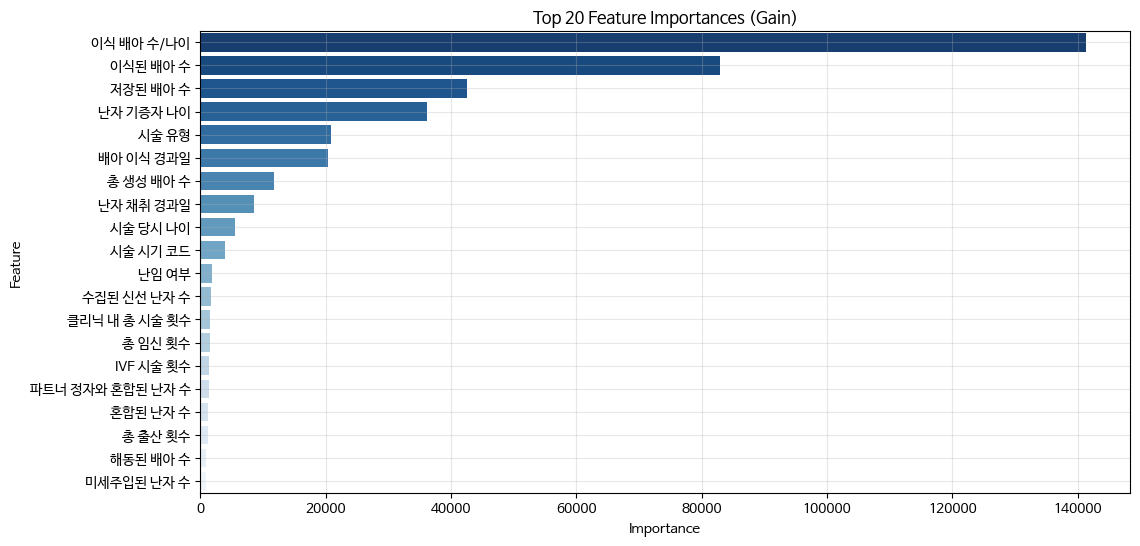

In [ ]:
plt.rc('font', family='NanumBarunGothic')
# 모든 Fold의 Feature Importance 저장
feature_importance_df = pd.DataFrame({'Feature': X_train.columns})

# 모든 모델의 중요도를 저장할 리스트
importance_list = []

for model in models:
    importance_list.append(model.feature_importance(importance_type="gain"))

# 평균 Feature Importance 계산
feature_importance_df["Importance"] = np.mean(importance_list, axis=0)

# 중요도 정렬 (상위 20개 선택)
feature_importance_top20 = feature_importance_df.sort_values(by="Importance", ascending=False).head(20)

# 그래프 출력
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_top20, palette="Blues_r")
plt.title("Top 20 Feature Importances (Gain)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.show()

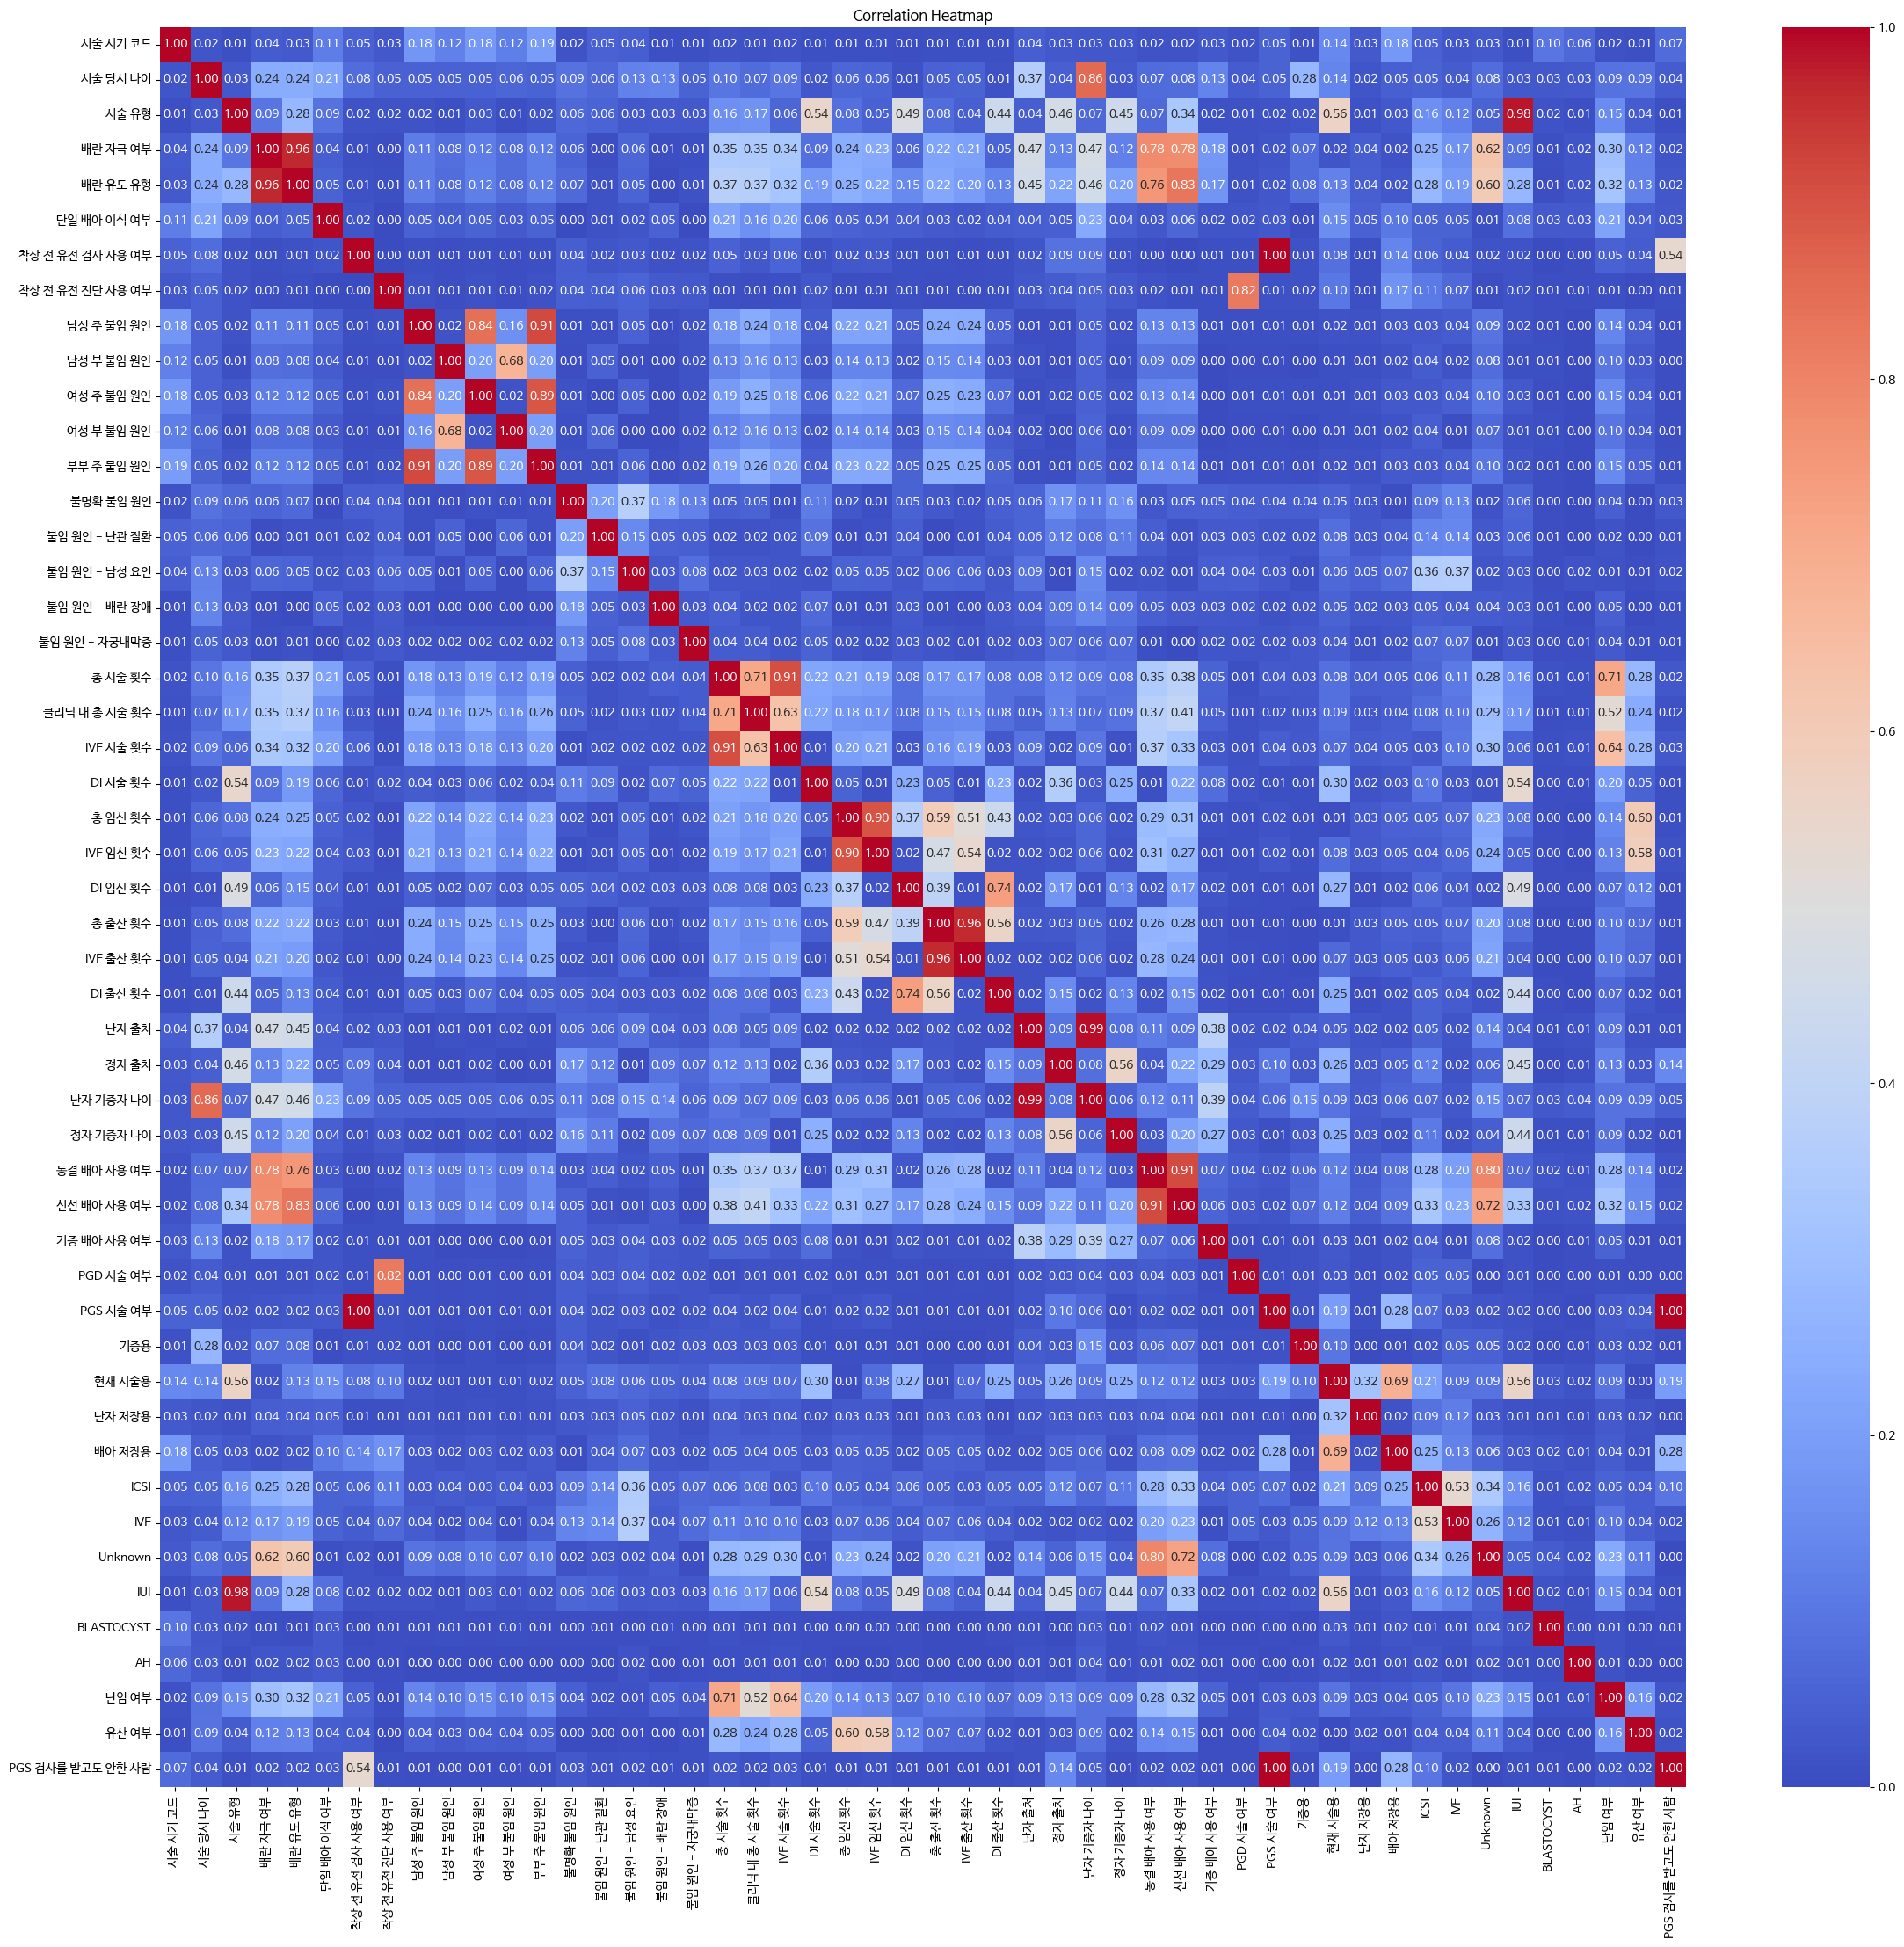

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def cramers_v(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, _, _, _ = stats.chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, c = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, c) - 1)))

# categorical_features에 있는 모든 범주형 변수의 Cramer's V 계산
corr_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0  # 자기 자신과의 관계는 1
        else:
            corr_matrix.loc[col1, col2] = cramers_v(train_df, col1, col2)

# 숫자로 변환 (float)
corr_matrix = corr_matrix.astype(float)

# 히트맵
plt.figure(figsize=(28, 26))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
from collections import defaultdict
from sklearn.utils import shuffle
import numpy as np

def check_auc_impact_avg(models, X_vals, y_vals):
    auc_changes = defaultdict(list)  # 각 컬럼별 AUC 변화 저장

    for i, model in enumerate(models):
        X_val = X_vals[i]
        y_val = y_vals[i]

        auc_original = roc_auc_score(y_val, model.predict(X_val))  # 기존 AUC

        for col in X_val.columns:
            X_shuffled = X_val.copy()
            X_shuffled[col] = shuffle(X_shuffled[col].values, random_state=42)  # 해당 컬럼 섞기

            y_pred_proba = model.predict(X_shuffled)
            auc_new = roc_auc_score(y_val, y_pred_proba)

            auc_changes[col].append(auc_new - auc_original)  # AUC 변화 저장

    # 각 컬럼별 평균 AUC 변화 계산
    auc_changes_avg = {col: np.mean(changes) for col, changes in auc_changes.items()}

    # AUC 변화 기준 정렬
    auc_changes_avg = sorted(auc_changes_avg.items(), key=lambda x: x[1])

    return auc_changes_avg

# 각 Fold의 검증 데이터셋을 리스트로 저장
X_vals = []
y_vals = []

for train_idx, valid_idx in skf.split(X_train, y_train):
    X_vals.append(X_train.iloc[valid_idx])
    y_vals.append(y_train.iloc[valid_idx])

# AUC 변화 확인 (5개 Fold 평균)
auc_changes_avg = check_auc_impact_avg(models, X_vals, y_vals)
auc_changes_avg


[('이식된 배아 수', -0.06743562613512452),
 ('난자 기증자 나이', -0.03986699886021237),
 ('이식 배아 수/나이', -0.036014116521643214),
 ('저장된 배아 수', -0.019157023436594246),
 ('배아 이식 경과일', -0.01881126740835635),
 ('총 생성 배아 수', -0.006992735632635827),
 ('시술 시기 코드', -0.001929992104267453),
 ('시술 당시 나이', -0.001814519909192258),
 ('난자 채취 경과일', -0.0011989460121226482),
 ('수집된 신선 난자 수', -0.0010669589981129768),
 ('시술 유형', -0.0009987675989562295),
 ('총 임신 횟수', -0.0009462438133837958),
 ('총 출산 횟수', -0.0007548560751551969),
 ('난임 여부', -0.0006633212292980417),
 ('클리닉 내 총 시술 횟수', -0.0006191168819304372),
 ('미세주입이 아닌 배아 이식 수', -0.0006146305089658188),
 ('파트너 정자와 혼합된 난자 수', -0.0005881017122099097),
 ('불임 원인 - 난관 질환', -0.0005136933061819171),
 ('불임 원인 - 남성 요인', -0.00039525531531177106),
 ('배란 자극 여부', -0.0003932342862491112),
 ('미세주입된 난자 수', -0.0003851515491703816),
 ('기증용', -0.00036229536329854815),
 ('해동된 배아 수', -0.00032571181170519824),
 ('정자 출처', -0.0003130720484157079),
 ('IVF 시술 횟수', -0.0002955053681601205),
 ('혼합된

In [ ]:
# 0 이상인 AUC 변화량을 가진 컬럼만 리스트로 추출
important_columns = [col for col, change in auc_changes_avg if change >= 0]

print(important_columns)  # 결과 출력


['PGS 검사를 받고도 안한 사람', '현재 시술용', 'ICSI', '기증자 정자와 혼합된 난자 수', '불명확 불임 원인', '총 시술 횟수']


In [ ]:
# '불임'이 포함된 컬럼 필터링
for col, change in auc_changes_avg:
    if '부부' in col:
        print(f"{col}: {change:.4f}")


부부 주 불임 원인: -0.0000


## 분석1

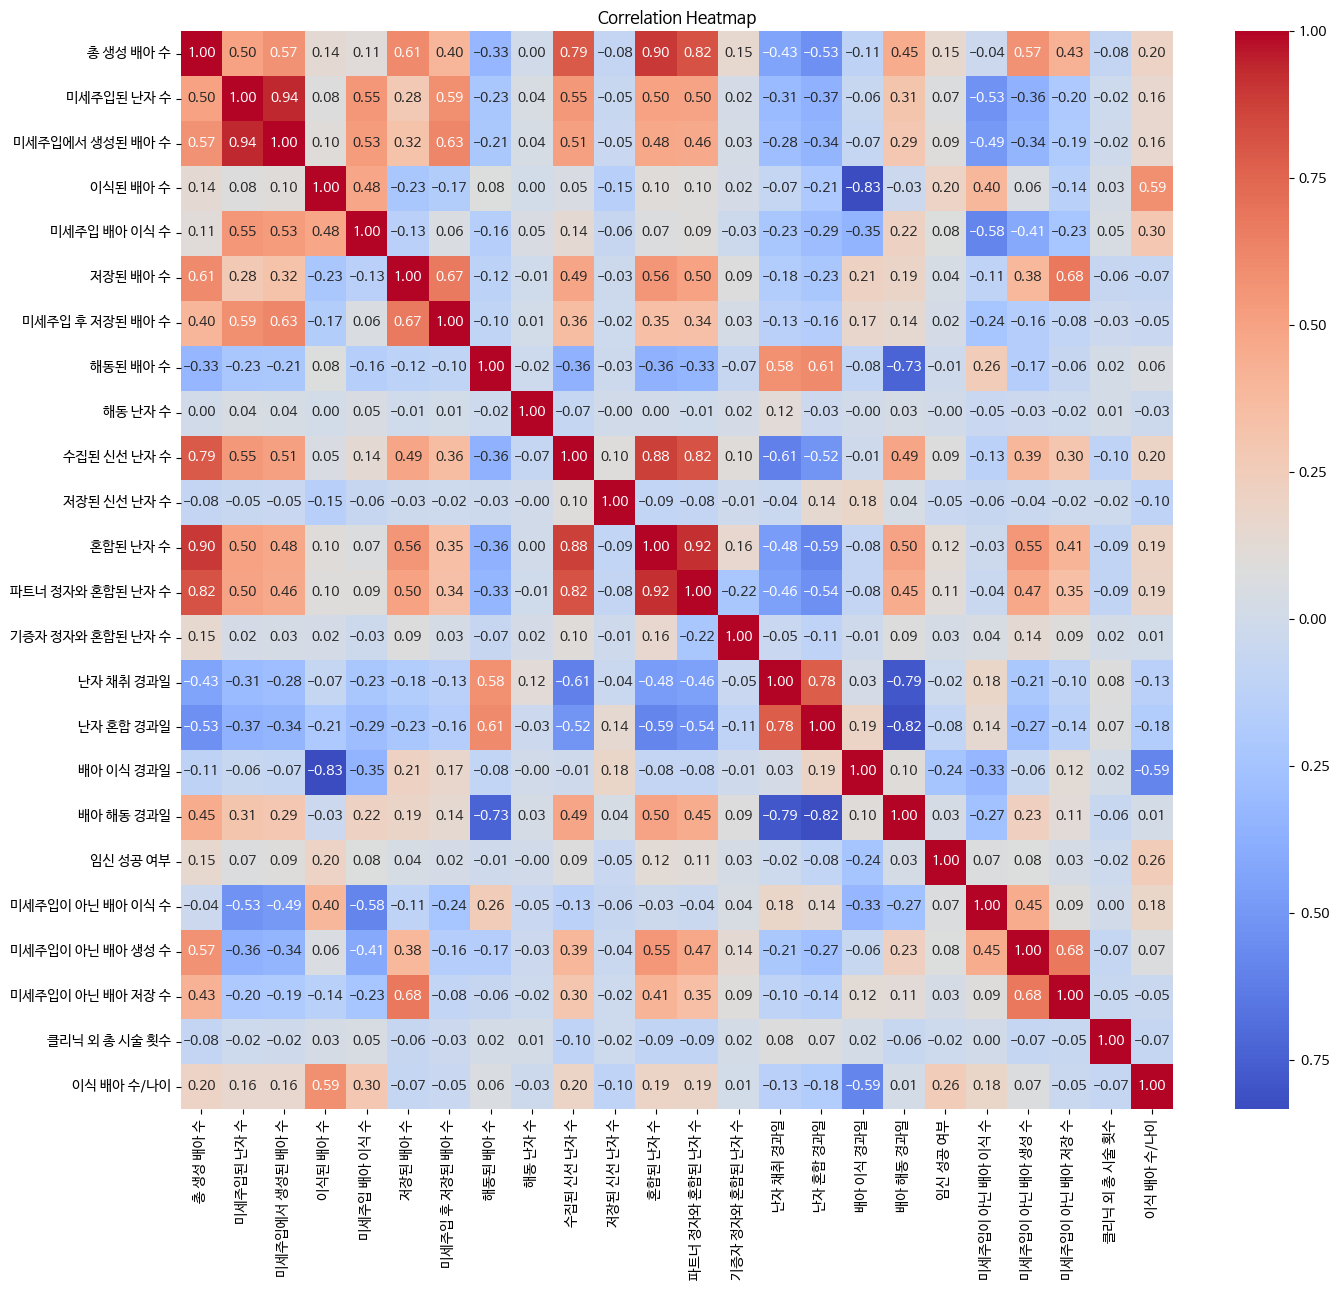

In [ ]:
# 수치형 변수만 상관관계
corr_matrix = train_df.select_dtypes(include=['number']).corr()
# 히트맵
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## 상관관계

In [ ]:
pd.set_option('display.max_rows', 100)

target_col = '임신 성공 여부'  # 상관관계를 확인할 컬럼명 지정
top_corr = corr_matrix[target_col].abs().nlargest(70).iloc[1:]  # 자기 자신 제외

print(top_corr)

배아 이식 경과일            0.241875
이식 배아 수/나이           0.231789
이식된 배아 수             0.204147
총 생성 배아 수            0.150716
혼합된 난자 수             0.121829
파트너 정자와 혼합된 난자 수     0.110433
미세주입에서 생성된 배아 수      0.094074
수집된 신선 난자 수          0.089444
난자 혼합 경과일            0.081604
미세주입이 아닌 배아 생성 수     0.079050
미세주입 배아 이식 수         0.079046
미세주입된 난자 수           0.074481
미세주입이 아닌 배아 이식 수     0.069473
저장된 신선 난자 수          0.046740
저장된 배아 수             0.039101
PGS 검사를 받고도 안한 사람    0.031990
배아 해동 경과일            0.029362
미세주입이 아닌 배아 저장 수     0.028961
기증자 정자와 혼합된 난자 수     0.027514
미세주입 후 저장된 배아 수      0.023969
클리닉 외 총 시술 횟수        0.023230
난자 채취 경과일            0.023222
해동된 배아 수             0.012406
해동 난자 수              0.001633
Name: 임신 성공 여부, dtype: float64


In [ ]:
# 상관관계 행렬에서 자기 자신과의 상관관계 및 중복 제거
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 상관관계가 높은 순으로 상위 20개 추출
top_20_corr_pairs = corr_pairs.unstack().dropna().abs().sort_values(ascending=False).head(40)

# 상위 20개의 상관관계 출력
print("Top 20 feature pairs with highest correlation:")
print(top_20_corr_pairs)

Top 20 feature pairs with highest correlation:
난자 혼합 경과일         PGD 시술 여부           1.000000
배아 해동 경과일         PGS 시술 여부           1.000000
배아 이식 경과일         착상 전 유전 검사 사용 여부    1.000000
IVF 임신 횟수         총 임신 횟수             0.962996
IVF 출산 횟수         총 출산 횟수             0.960738
난임 여부             총 시술 횟수             0.960180
미세주입에서 생성된 배아 수   미세주입된 난자 수          0.941089
대리모 여부            시술 유형               0.924973
파트너 정자와 혼합된 난자 수  혼합된 난자 수            0.916535
IVF 시술 횟수         총 시술 횟수             0.916159
부부 주 불임 원인        남성 주 불임 원인          0.914251
혼합된 난자 수          총 생성 배아 수           0.896275
부부 주 불임 원인        여성 주 불임 원인          0.892825
DI 출산 횟수          DI 임신 횟수            0.878279
혼합된 난자 수          수집된 신선 난자 수         0.877720
난임 여부             IVF 시술 횟수           0.870537
기증 배아 사용 여부       시술 유형               0.848517
여성 주 불임 원인        남성 주 불임 원인          0.841564
배아 해동 경과일         착상 전 유전 검사 사용 여부    0.841137
배아 이식 경과일         PGS 시술 여부           0.841137
배아 해동 경과일    

In [ ]:
# 상관관계 행렬에서 자기 자신과의 상관관계 및 중복 제거
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 상관관계가 높은 순으로 상위 20개 변수 쌍 추출
top_20_corr_pairs = corr_pairs.unstack().dropna().abs().sort_values(ascending=False).head(40)

# 변수 쌍 추출
top_20_feature_pairs = top_20_corr_pairs.index.tolist()

# 교차 테이블 및 시각화
for feature1, feature2 in top_20_feature_pairs:
    print(f"Cross-tabulation between {feature1} and {feature2}:\n")

    # 교차표 생성
    crosstab_result = pd.crosstab(df[feature1], df[feature2])
    display(crosstab_result, "\n")

## 후분석

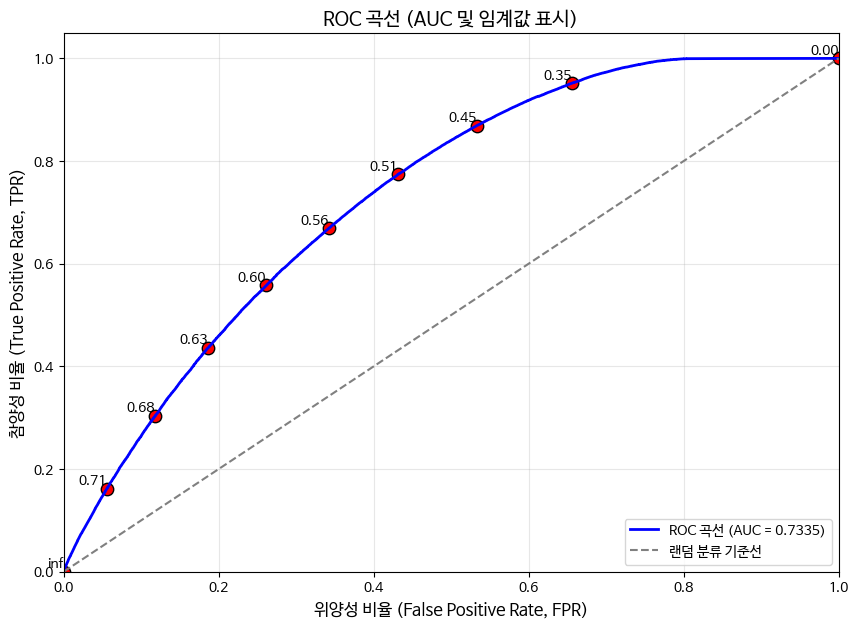

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_pred_proba)  # 전체 K-Fold 예측값 사용
roc_auc = roc_auc_score(all_y_true, all_y_pred_proba)

# ROC Curve 시각화
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC 곡선 (AUC = {roc_auc:.4f})')  # AUC 값 포함
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="랜덤 분류 기준선")  # 랜덤 분류기 기준선

# 주요 임계값(thresholds) 표시
threshold_points = np.linspace(0, len(thresholds) - 1, 10, dtype=int)  # 10개 지점 선택
for i in threshold_points:
    plt.scatter(fpr[i], tpr[i], marker='o', color='red', edgecolors='black', s=80)
    plt.text(fpr[i], tpr[i], f"{thresholds[i]:.2f}", fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 축 및 제목 설정
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('위양성 비율 (False Positive Rate, FPR)', fontsize=12)
plt.ylabel('참양성 비율 (True Positive Rate, TPR)', fontsize=12)
plt.title('ROC 곡선 (AUC 및 임계값 표시)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# 그래프 출력
plt.show()


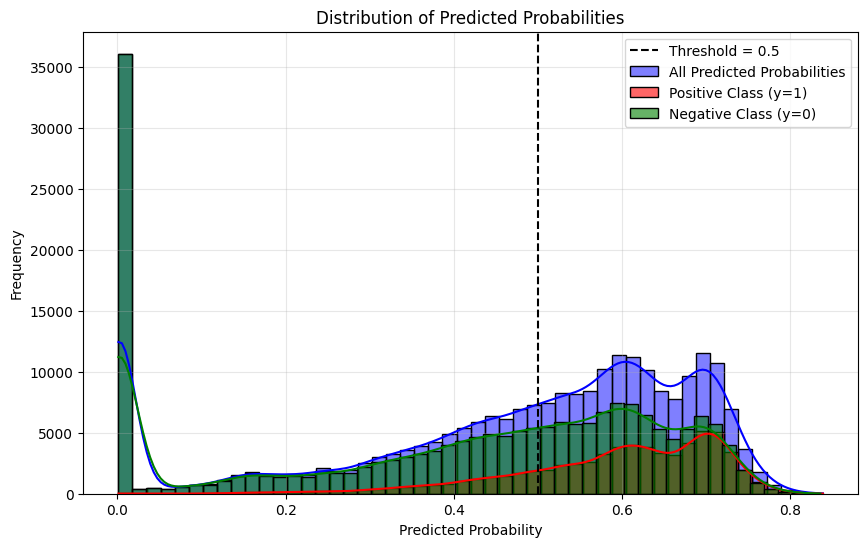

In [ ]:
## 확률값 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(all_y_pred_proba, bins=50, kde=True, color='blue', label='All Predicted Probabilities', alpha=0.5)
sns.histplot(np.array(all_y_pred_proba)[np.array(all_y_true) == 1], bins=50, kde=True, color='red', label='Positive Class (y=1)', alpha=0.6)
sns.histplot(np.array(all_y_pred_proba)[np.array(all_y_true) == 0], bins=50, kde=True, color='green', label='Negative Class (y=0)', alpha=0.6)
plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.grid(alpha=0.3)
plt.show()